In [12]:
# MINIMALLY, NEED PARQUETS TO RUN FROM "START HERE" CELL
# RUN ONLY THIS CELL IF HAVE PARQUETS AND NOT GENERATING PARQUETS FROM SCRATCH
import pandas as pd
import sqlite3
import math
import matplotlib.pyplot as plt
import os

# uses positioning information from GeoNames (https://www.geonames.org) to find landfall country/state from coordinates
# GeoNames database from https://download.geonames.org/export/dump/
# need US, Mexico, and Canada to differentiate landfalls that are close
geonames_dbs_txt = ['US/US.txt', 'MX/MX.txt', 'CA/CA.txt']
# this will be created in the cell below
geonames_db_sqlite = 'USMXCA.sqlite'

# best track data from https://www.ncei.noaa.gov/data/international-best-track-archive-for-climate-stewardship-ibtracs/v04r00/access/csv/
best_tracks_na_csv = 'ibtracs.NA.list.v04r00.csv'
best_tracks_ep_csv = 'ibtracs.EP.list.v04r00.csv'

# Constants for Earth's radius in kilometers
EARTH_RADIUS_KM = 6371.0

# for calculating probabilities
default_start_year = 1851
default_end_year = 2002

# Function to calculate the Haversine distance between two coordinates
def haversine_distance(lat1, lon1, lat2, lon2):
    # Convert latitude and longitude from degrees to radians
    lat1 = math.radians(lat1)
    lon1 = math.radians(lon1)
    lat2 = math.radians(lat2)
    lon2 = math.radians(lon2)

    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    distance = EARTH_RADIUS_KM * c

    return distance


def find_nearest_country_and_state(conn, lat, lon):
    cursor = conn.cursor()
    
    # Query the database to find the nearest place based on coordinates
    cursor.execute("""
        SELECT country, state, latitude, longitude FROM geonames
        WHERE latitude BETWEEN ? AND ?
        AND longitude BETWEEN ? AND ?
        ORDER BY ((latitude - ?) * (latitude - ?) + (longitude - ?) * (longitude - ?))
        LIMIT 1
    """, (lat - 1, lat + 1, lon - 1, lon + 1, lat, lat, lon, lon))

    result = cursor.fetchone()
    cursor.close()

    if result:
        country, state, place_lat, place_lon = result
        if str(state) != '00':
            distance = haversine_distance(lat, lon, place_lat, place_lon)
            return country, state, distance

    return None, None, None

# create a new empty dataframe with same template
def copy_df_structure(df_reference):
    new_df = df_reference.copy(deep=False)
    new_df.astype(df_reference.dtypes.to_dict())
    new_df = new_df[0:0]
    return new_df

# add landfall state for all US tropical storms and subtropical storms
def get_us_landfalls(df_reference):
    df_new_landfalls = copy_df_structure(df_reference)
    df_new_landfalls = df_new_landfalls.reset_index(drop=True)
    US_state_abbrevs = [ 'AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA',
       'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME',
       'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM',
       'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX',
       'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY']

    # Connect to the SQLite database containing Geonames data
    conn = sqlite3.connect(geonames_db_sqlite)
    us_state_landfalls = []
    for i in range(len(df_reference)):
        entry = df_reference.iloc[i]
        latitude = float(entry['USA_LAT'])
        longitude = float(entry['USA_LON'])

        country, state, distance_km = find_nearest_country_and_state(conn, latitude, longitude)
        # it may return state='00' if Mexico is not in sqlite database so double check state is in abbrevs
        if country == 'US' and state in US_state_abbrevs:
            df_new_landfalls.loc[len(df_new_landfalls)] = entry
            df_new_landfalls = df_new_landfalls.reset_index(drop=True)
            us_state_landfalls.append(state)

    # Don't forget to close the database connection when you're done
    conn.close()

    df_new_landfalls = df_new_landfalls.reset_index(drop=True)
    df_new_landfalls_with_state = df_new_landfalls.copy(deep=True)
    df_new_landfalls_with_state = df_new_landfalls_with_state.assign(LANDFALL_STATE=us_state_landfalls)
    return df_new_landfalls_with_state

# get the df with us landfall states (or the unique storms when no state supplied), selected by:
#     start/end year,
#     a list of US states where landfall occured (must be a list)
#     from a range within each year (start/end month and day; both must be supplied)
def get_landfalling_conditional(df_reference, states=None,
                                start_year=default_start_year, end_year=default_end_year,
                                start_month_num=None, start_day_num_of_month=None,
                                end_month_num=None, end_day_num_of_month=None):
    # might have multiple landfalls with the same storm, so only count each storm once
    df_new = df_reference.copy(deep=True)
    year_range = list(range(start_year, end_year + 1, 1))
    if states is not None:
        df_new = df_new.loc[(df_new['SEASON'].isin(year_range)) & (df_new['LANDFALL_STATE'].isin(states))]
    else:
        df_new = df_new.loc[(df_new['SEASON'].isin(year_range))]
    df_new = df_new.reset_index(drop=True)
    # get the mataching year and state first, then drop storm duplicates
    df_new = df_new.drop_duplicates(subset=['USA_ATCF_ID'])
    df_new = df_new.reset_index(drop=True)
    if start_month_num and end_month_num and start_day_num_of_month and end_day_num_of_month:
        # Only include those within the month-day range (inclusive)
        df_new['month'] = df_new['ISO_TIME'].dt.month
        df_new['day'] = df_new['ISO_TIME'].dt.day
        df_new['month_day_sum'] = (df_new['month'] * 100) + df_new['day']
        start_month_day_sum = (start_month_num * 100) + start_day_num_of_month
        end_month_day_sum = (end_month_num * 100) + end_day_num_of_month
        df_new = df_new.loc[
            (df_new['month_day_sum'] >= start_month_day_sum) &
            (df_new['month_day_sum'] <= end_month_day_sum)
        ]
        df_new = df_new.reset_index(drop=True)

    return df_new

# calculate expected probability for exactly expected_num_events this year, given:
#   that a total of num_events have happened over num_years
def poisson_pmf(num_years, num_events, expected_num_events):
    p = num_events / num_years
    xfact = math.factorial(expected_num_events)
    ep = math.pow(p, expected_num_events) / (math.exp(p) * xfact)
    return ep

In [104]:

















############################################### 
#### VERY SLOW ... SKIP TO "START HERE"
###############################################























In [105]:
# create the geonames db (only do once!)

## ONLY RUN THIS CELL ONCE
if not os.path.isfile(geonames_db_sqlite):
    # Create a new SQLite database or connect to an existing one
    conn = sqlite3.connect(geonames_db_sqlite)
    cursor = conn.cursor()

    # Create a table to store the Geonames data
    cursor.execute('''
        CREATE TABLE geonames (
            geonameid INTEGER PRIMARY KEY,
            name TEXT,
            latitude REAL,
            longitude REAL,
            country TEXT,
            state TEXT
        )
    ''')

    for geonames_db_txt in geonames_dbs_txt:
        # Read and import data from the "US.txt" file into the database
        with open(geonames_db_txt, 'r', encoding='utf-8') as file:
            for line in file:
                parts = line.strip().split('\t')
                if len(parts) >= 10:
                    geonameid, name, latitude, longitude, country, state = (
                        int(parts[0]), parts[1], float(parts[4]), float(parts[5]), parts[8], parts[10]
                    )
                    cursor.execute('''
                        INSERT INTO geonames (geonameid, name, latitude, longitude, country, state)
                        VALUES (?, ?, ?, ?, ?, ?)
                    ''', (geonameid, name, latitude, longitude, country, state))

    # Commit changes and close the database connection
    conn.commit()
    conn.close()


In [106]:
#############################################################################
# READ THE TRACKS AND DO THE LANDFALL CALCULATIONS IN BELOW CELLS (VERY SLOW)
# ONLY NEED TO DO ONCE SINCE PARQUETS ARE PRECOMPUTED
#############################################################################

In [107]:
# Read the CSV file into a DataFrame without automatically assigning column names
df_na = pd.read_csv(best_tracks_na_csv, header=0, skiprows=[1], low_memory=False)
df_ep = pd.read_csv(best_tracks_ep_csv, header=0, skiprows=[1], low_memory=False)
# store all related basin dataframes in one list, with the main one (read from file) separately
dfs_by_basin = {'NA': {'main': df_na}, 'EP': {'main': df_ep}}

In [108]:
# get ts/ss/hu storms (>=34kt) for both basins (north atlantic and east pacific)
for basin_name, dict_dfs in dfs_by_basin.items():
    df = dict_dfs['main'].copy(deep=True)
    # Create a dictionary that specifies the data types for each column
    dtype_mapping = {
        'LAT': float,
        'LON': float,
        'WMO_WIND': float,
        'WMO_PRES': float,
        'USA_WIND': float,
        'DIST2LAND': float,
        'LANDFALL': float,
        'STORM_SPEED': float,
        'STORM_DIR': float
    }

    # Apply dtype conversion to specific columns, treating non-numeric values as NaN
    for column, data_type in dtype_mapping.items():
        df[column] = pd.to_numeric(df[column], errors='coerce').astype(data_type)

    # convert time to datetime
    df['ISO_TIME'] = pd.to_datetime(df['ISO_TIME'])

    # get landfalls
    df_td_sd = df.loc[(df['USA_WIND'] < 34) & (df['USA_STATUS'].isin(['TD', 'SD']))]
    df_ts_ss = df.loc[(df['USA_WIND'] >= 34) & (df['USA_STATUS'].isin(['TS', 'SS']))]
    df_hu = df.loc[(df['USA_WIND'] >= 34) & (df['USA_STATUS'].isin(['HU', 'HR']))]
    df_ts_ss = df_ts_ss.reset_index(drop=True)
    df_hu = df_hu.reset_index(drop=True)
    df_ts_ss_hu = pd.concat([df_ts_ss,df_hu])
    df_ts_ss_hu = df_ts_ss_hu.reset_index(drop=True)    
    
    dict_dfs['td_sd'] = df_td_sd
    dict_dfs['ts_ss'] = df_ts_ss
    dict_dfs['hu'] = df_hu
    dict_dfs['ts_ss_hu'] = df_ts_ss_hu
    dfs_by_basin[basin_name] = dict_dfs

In [109]:
# get landfalls for ts/ss/hu (>=34kt) and compute landfall states for both basins (north atlantic and east pacific)
#   only include rows with unique landfall state/storm combinations:
#      don't have rows for storm that have landfalling twice in same storm
#   so, there may be multiple landfalls per storm if a storm landfalls in multiple states,
#      but each state will have a specific storm landfalling only once in that state
for basin_name, dict_dfs in dfs_by_basin.items():
    df = dict_dfs['main'].copy(deep=True)
    # Create a dictionary that specifies the data types for each column
    dtype_mapping = {
        'LAT': float,
        'LON': float,
        'WMO_WIND': float,
        'WMO_PRES': float,
        'USA_WIND': float,
        'DIST2LAND': float,
        'LANDFALL': float,
        'STORM_SPEED': float,
        'STORM_DIR': float
    }

    # Apply dtype conversion to specific columns, treating non-numeric values as NaN
    for column, data_type in dtype_mapping.items():
        df[column] = pd.to_numeric(df[column], errors='coerce').astype(data_type)

    # convert time to datetime
    df['ISO_TIME'] = pd.to_datetime(df['ISO_TIME'])

    # get landfalls
    df_landfalls = df.loc[(df['USA_RECORD'] == 'L')]
    df_td_sd_landfalls = df_landfalls.loc[(df_landfalls['USA_WIND'] < 34) & (df_landfalls['USA_STATUS'].isin(['TD', 'SD']))]
    df_ts_ss_landfalls = df_landfalls.loc[(df_landfalls['USA_WIND'] >= 34) & (df_landfalls['USA_STATUS'].isin(['TS', 'SS']))]
    df_hu_landfalls = df_landfalls.loc[(df_landfalls['USA_WIND'] >= 34) & (df_landfalls['USA_STATUS'].isin(['HU', 'HR']))]
    df_landfalls = df_landfalls.reset_index(drop=True)
    df_td_sd_landfalls = df_td_sd_landfalls.reset_index(drop=True)
    df_ts_ss_landfalls = df_ts_ss_landfalls.reset_index(drop=True)
    df_hu_landfalls = df_hu_landfalls.reset_index(drop=True)
    
    # this will take a while as geonames is slow
    df_us_td_sd_landfalls_with_state = get_us_landfalls(df_td_sd_landfalls)
    df_us_ts_ss_landfalls_with_state = get_us_landfalls(df_ts_ss_landfalls)
    df_us_hu_landfalls_with_state = get_us_landfalls(df_hu_landfalls)
    
    # for the above landfalls there are duplicates for a single state with different timestamps
    df_us_td_sd_landfalls_with_state_no_dupe_times = df_us_td_sd_landfalls_with_state.drop_duplicates(subset=['LANDFALL_STATE', 'USA_ATCF_ID'])
    df_us_ts_ss_landfalls_with_state_no_dupe_times = df_us_ts_ss_landfalls_with_state.drop_duplicates(subset=['LANDFALL_STATE', 'USA_ATCF_ID'])
    df_us_hu_landfalls_with_state_no_dupe_times = df_us_hu_landfalls_with_state.drop_duplicates(subset=['LANDFALL_STATE', 'USA_ATCF_ID'])
    df_us_ts_ss_hu_landfalls_with_state_no_dupe_times = pd.concat([df_us_ts_ss_landfalls_with_state_no_dupe_times, df_us_hu_landfalls_with_state_no_dupe_times])
    df_us_ts_ss_hu_landfalls_with_state_no_dupe_times = df_us_ts_ss_hu_landfalls_with_state_no_dupe_times.drop_duplicates(subset=['LANDFALL_STATE', 'USA_ATCF_ID'])

    dict_dfs['us_landfalls_td_sd'] = df_us_td_sd_landfalls_with_state_no_dupe_times
    dict_dfs['us_landfalls_ts_ss'] = df_us_ts_ss_landfalls_with_state_no_dupe_times
    dict_dfs['us_landfalls_hu'] = df_us_hu_landfalls_with_state_no_dupe_times
    dict_dfs['us_landfalls_ts_ss_hu'] = df_us_ts_ss_hu_landfalls_with_state_no_dupe_times
    dfs_by_basin[basin_name] = dict_dfs

In [110]:
# write the parquets
for basin_name, dict_dfs in dfs_by_basin.items():
    for df_name, dict_df in dict_dfs.items():
        parquet_name = basin_name + '_basin_' + df_name + ".parquet"
        dict_df.to_parquet(parquet_name)

In [111]:
print(dfs_by_basin['NA'].keys())
print(dfs_by_basin['EP'].keys())

dict_keys(['main', 'td_sd', 'ts_ss', 'hu', 'ts_ss_hu', 'us_landfalls_td_sd', 'us_landfalls_ts_ss', 'us_landfalls_hu', 'us_landfalls_ts_ss_hu'])
dict_keys(['main', 'td_sd', 'ts_ss', 'hu', 'ts_ss_hu', 'us_landfalls_td_sd', 'us_landfalls_ts_ss', 'us_landfalls_hu', 'us_landfalls_ts_ss_hu'])


In [112]:
# COMBINE NA AND EP for US landfalling storms

# do for both basins (north atlantic and east pacific)
# because of the import NA got imported as nan
dfs_na_ep_us_landfalls = {}
dfs_tmp = {
    'ts_ss': [],
    'hu': [],
    'ts_ss_hu': []
}
# includes storms that cross basins
for basin_name, dict_dfs in dfs_by_basin.items():
    # get storms    
    df_us_landfalls_ts_ss = dict_dfs['us_landfalls_ts_ss'].copy(deep=True)
    df_us_landfalls_hu = dict_dfs['us_landfalls_hu'].copy(deep=True)
    df_us_landfalls_ts_ss_hu = dict_dfs['us_landfalls_ts_ss_hu'].copy(deep=True)
    
    dfs_tmp['ts_ss'].append(df_us_landfalls_ts_ss)
    dfs_tmp['hu'].append(df_us_landfalls_hu)
    dfs_tmp['ts_ss_hu'].append(df_us_landfalls_ts_ss_hu)

# concat the dfs for the basins
for dict_name, dict_dfs in dfs_tmp.items():
    dfs_na_ep_us_landfalls[dict_name] = pd.concat(dict_dfs)
    dfs_na_ep_us_landfalls[dict_name] = dfs_na_ep_us_landfalls[dict_name].reset_index(drop=True)

In [113]:
# write the parquets
for df_name, dict_df in dfs_na_ep_us_landfalls.items():
    parquet_name = 'na_ep_us_landfalls_' + df_name + ".parquet"
    dict_df.to_parquet(parquet_name)

In [114]:
# COMBINE NA AND EP for all storms

# do for both basins (north atlantic and east pacific)
# because of the import NA got imported as nan
dfs_na_ep = {}
dfs_tmp = {
    'ts_ss': [],
    'hu': [],
    'ts_ss_hu': []
}
# includes storms that cross basins
for basin_name, dict_dfs in dfs_by_basin.items():
    # get storms    
    df_ts_ss = dict_dfs['ts_ss'].copy(deep=True)
    df_hu = dict_dfs['hu'].copy(deep=True)
    df_ts_ss_hu = dict_dfs['ts_ss_hu'].copy(deep=True)
    
    dfs_tmp['ts_ss'].append(df_ts_ss)
    dfs_tmp['hu'].append(df_hu)
    dfs_tmp['ts_ss_hu'].append(df_ts_ss_hu)

# concat the dfs for the basins
for dict_name, dict_dfs in dfs_tmp.items():
    dfs_na_ep[dict_name] = pd.concat(dict_dfs)
    dfs_na_ep[dict_name] = dfs_na_ep[dict_name].reset_index(drop=True)

In [115]:
# write the parquets
for df_name, dict_df in dfs_na_ep.items():
    parquet_name = 'na_ep_' + df_name + ".parquet"
    #print(parquet_name)
    dict_df.to_parquet(parquet_name)

In [3]:























#######################
##### START HERE ######
#######################

# FIRST, RUN THE FIRST CELL, THEN THESE BELOW















In [13]:
# LOAD THE PARQUETS BY BASIN 

parquets_by_basin_for_us_landfalls = [
'EP_basin_main.parquet',
'EP_basin_us_landfalls_td_sd.parquet',
'EP_basin_us_landfalls_ts_ss.parquet',
'EP_basin_us_landfalls_hu.parquet',
'EP_basin_us_landfalls_ts_ss_hu.parquet',
'EP_basin_td_sd.parquet',
'EP_basin_ts_ss.parquet',
'EP_basin_hu.parquet',
'EP_basin_ts_ss_hu.parquet',
'NA_basin_main.parquet',
'NA_basin_us_landfalls_td_sd.parquet',
'NA_basin_us_landfalls_ts_ss.parquet',
'NA_basin_us_landfalls_hu.parquet',
'NA_basin_us_landfalls_ts_ss_hu.parquet',
'NA_basin_td_sd.parquet',
'NA_basin_ts_ss.parquet',
'NA_basin_hu.parquet',
'NA_basin_ts_ss_hu.parquet',
]

dfs_by_basin = {}
for parquet_file_name in parquets_by_basin_for_us_landfalls:
    parquet_name = parquet_file_name.replace(".parquet", "")
    basin_name, df_name = parquet_name.split('_basin_')
    if basin_name not in dfs_by_basin:
        dfs_by_basin[basin_name] = {}
    dict_dfs = dfs_by_basin[basin_name]
    dict_dfs[df_name] = pd.read_parquet(parquet_file_name)
    dfs_by_basin[basin_name] = dict_dfs

In [14]:
# LOAD THE PARQUETS BY STORM TYPES FOR US LANDFALLS

parquets_by_storm_types_for_us_landfalls = [
'na_ep_us_landfalls_hu.parquet',
'na_ep_us_landfalls_ts_ss.parquet',
'na_ep_us_landfalls_ts_ss_hu.parquet'
]

dfs_na_ep_us_landfalls = {}
for parquet_file_name in parquets_by_storm_types_for_us_landfalls:
    parquet_name = parquet_file_name.replace(".parquet", "")
    prefix, df_name = parquet_name.split('na_ep_us_landfalls_')
    dfs_na_ep_us_landfalls[df_name] = pd.read_parquet(parquet_file_name)

In [15]:
# LOAD THE PARQUETS BY STORM TYPES FOR ALL STORMS

parquets_by_storm_types = [
'na_ep_hu.parquet',
'na_ep_ts_ss.parquet',
'na_ep_ts_ss_hu.parquet'
]

dfs_na_ep = {}
for parquet_file_name in parquets_by_storm_types:
    parquet_name = parquet_file_name.replace(".parquet", "")
    prefix, df_name = parquet_name.split('na_ep_')
    dfs_na_ep[df_name] = pd.read_parquet(parquet_file_name)

# US Named Storm landfalls (>=34 kt) in records from North Atlantic and East Pacific basins: 516
# US Named Storm landfalls (>=34 kt) from North Atlantic and East Pacific basins, 1991 to 2023 from 11-3 to 11-30 in all US states: 4
PMF % (starting from 0): [88.5846032927707, 10.737527671850994, 0.6507592528394542, 0.02629330314502845, 0.0007967667619705591, 1.931555786595295e-05, 3.9021329022127176e-07, 6.756940090411631e-09, 1.02377880157752e-10, 1.3788266687912728e-12]
Cumulative % (starting from 0): [99.99999999999997, 11.415396707229277, 0.6778690353782828, 0.027109782538828564, 0.0008164793938001125, 1.9712631829553375e-05, 3.970739636004249e-07, 6.860673379153126e-09, 1.0373328874149432e-10, 1.3554085837423093e-12]


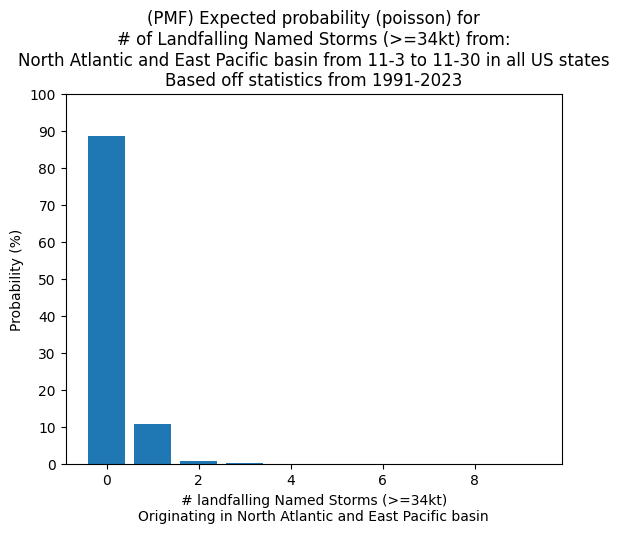

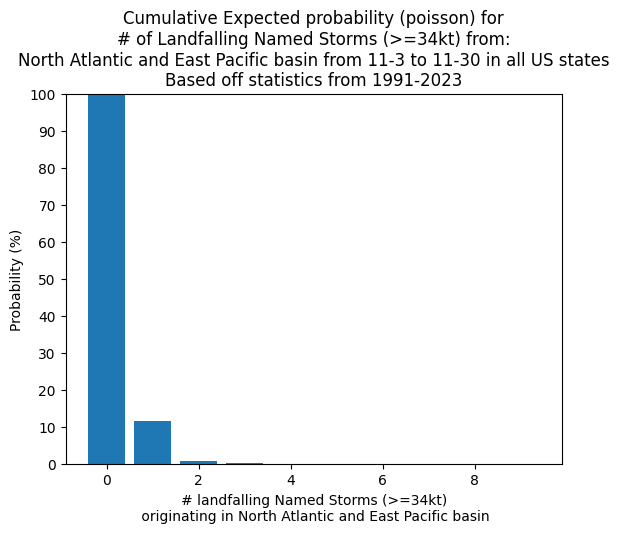

In [137]:
##### COMBINED NA AND EP BASIN STATISTICS FOR US LANDFALLS FOR NAMED STORMS (>= 34kt)
# set optionally either to None (default 1991-2023)
start_year = 1991
end_year = 2023
# must include all as None or with numbered month and day
start_month = None
start_day = None
end_month = None
end_day = None
start_month = 11
start_day = 3
end_month = 11
end_day = 30
# either None, or a list of 2 letter states to include
states = None
#states = ['NY', 'NJ']

if start_month and start_day and end_month and end_day:
    sub_period_str = f'from {start_month}-{start_day} to {end_month}-{end_day}'
else:
    sub_period_str = 'in a year'

states_str = 'in '
if states:
    states_str += ','.join(states)
else:
    states_str += 'all US states'

full_basin_name = "North Atlantic and East Pacific"

df_ref_with_state = dfs_na_ep_us_landfalls['ts_ss_hu'].copy(deep=True)
    
# with state has duplicate rows to record storms with multiple landfalls, so get only the unique storms for a count
df_unique_storms = df_ref_with_state.drop_duplicates(subset=['USA_ATCF_ID'])
df_unique_storms = df_unique_storms.reset_index(drop=True)
print(f"# US Named Storm landfalls (>=34 kt) in records from {full_basin_name} basins:", len(df_unique_storms))

landfalling_in_period = get_landfalling_conditional(
    df_ref_with_state,
    states=states,
    start_year=start_year, end_year=end_year,
    start_month_num=start_month, start_day_num_of_month=start_day,
    end_month_num=end_month, end_day_num_of_month=end_day
)
#print(landfalling_in_period)
num_years = (end_year - start_year + 1)
num_in_period = len(landfalling_in_period)
print(f"# US Named Storm landfalls (>=34 kt) from {full_basin_name} basins, {start_year} to {end_year} {sub_period_str} {states_str}:", num_in_period)

event_counts = list(range(0,10))
pmf_pct_per_event_count = []
cum_pct_per_event_count = []
pct_total = 0
for n in event_counts:
    pct = 100 * poisson_pmf(num_years, num_in_period, n)
    pct_total += pct
    pmf_pct_per_event_count.append(pct)

remaining_pct = pct_total
# get cumulative probability from pmf
for pct in pmf_pct_per_event_count:
    cum_pct_per_event_count.append(remaining_pct)
    remaining_pct = remaining_pct - pct

print("PMF % (starting from 0):", pmf_pct_per_event_count)
print("Cumulative % (starting from 0):", cum_pct_per_event_count)

# Create a bar chart
plt.bar(event_counts, pmf_pct_per_event_count)

plt.ylim(0, 100)
plt.yticks(range(0, 101, 10))

# Label the axes and give the chart a title
plt.xlabel(f'# landfalling Named Storms (>=34kt)\nOriginating in {full_basin_name} basin')
plt.ylabel('Probability (%)')
plt.title(f"(PMF) Expected probability (poisson) for\n# of Landfalling Named Storms (>=34kt) from:\n" +
          f"{full_basin_name} basin {sub_period_str} {states_str}\n" +
          f"Based off statistics from {start_year}-{end_year}")

# Show the chart
plt.show()

# Cumulative Probabilities chart
plt.bar(event_counts, cum_pct_per_event_count)

plt.ylim(0, 100)
plt.yticks(range(0, 101, 10))

# Label the axes and give the chart a title
plt.xlabel(f'# landfalling Named Storms (>=34kt)\n originating in {full_basin_name} basin')
plt.ylabel('Probability (%)')
plt.title(f"Cumulative Expected probability (poisson) for\n# of Landfalling Named Storms (>=34kt) from:\n" +
          f"{full_basin_name} basin {sub_period_str} {states_str}\n" +
          f"Based off statistics from {start_year}-{end_year}")
plt.show()

# US Tropical/Subtropical Storm landfalls in records from East Pacific basin: 2
# US Tropical/Subtropical Storm landfalls from East Pacific basin, 1991 to 2023 from 11-1 to 11-30 in all US states: 0
PMF % (starting from 0): [100.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Cumulative % (starting from 0): [100.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


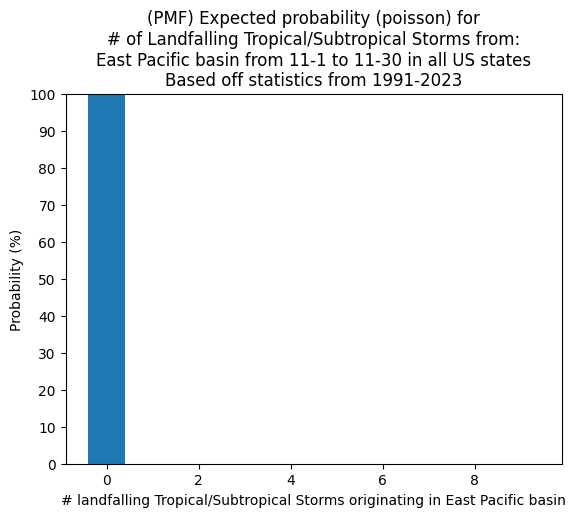

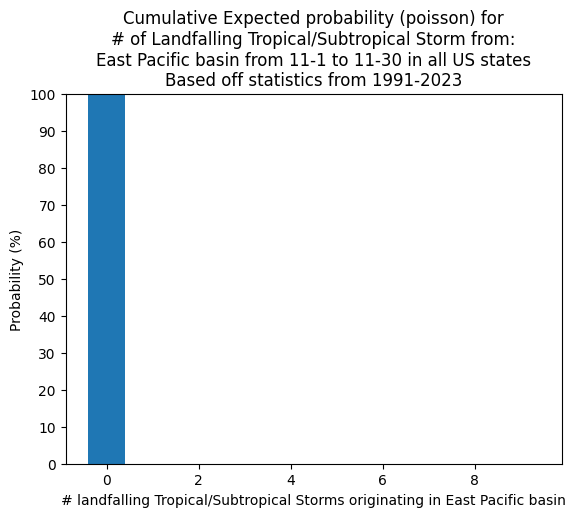

# US Hurricane landfalls in records from East Pacific basin: 4
# US Hurricane landfalls from East Pacific basin, 1991 to 2023 from 11-1 to 11-30 in all US states: 0
PMF % (starting from 0): [100.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Cumulative % (starting from 0): [100.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


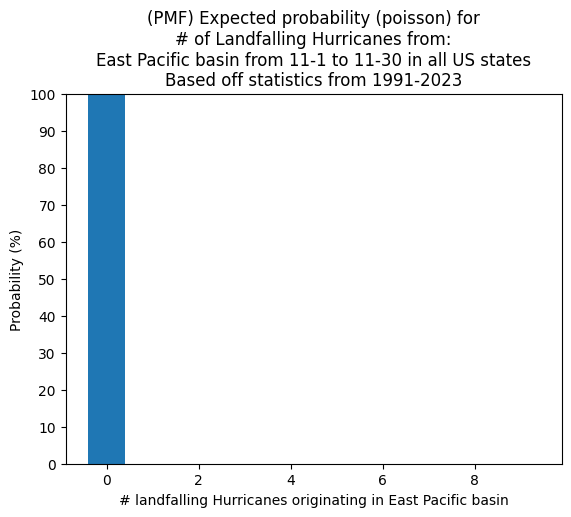

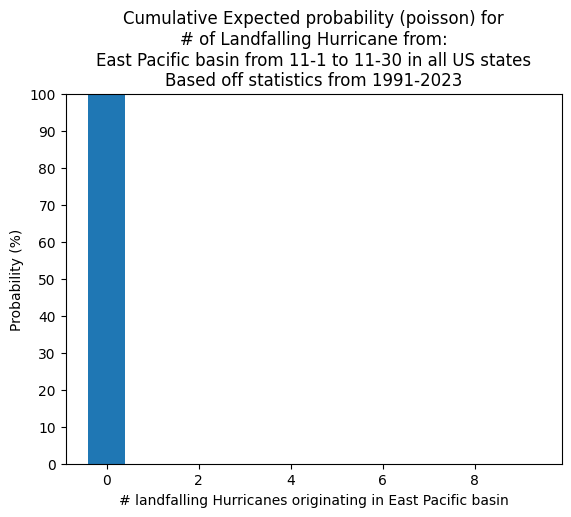

# US Tropical/Subtropical Storm landfalls in records from North Atlantic basin: 273
# US Tropical/Subtropical Storm landfalls from North Atlantic basin, 1991 to 2023 from 11-1 to 11-30 in all US states: 4
PMF % (starting from 0): [88.5846032927707, 10.737527671850994, 0.6507592528394542, 0.02629330314502845, 0.0007967667619705591, 1.931555786595295e-05, 3.9021329022127176e-07, 6.756940090411631e-09, 1.02377880157752e-10, 1.3788266687912728e-12]
Cumulative % (starting from 0): [99.99999999999997, 11.415396707229277, 0.6778690353782828, 0.027109782538828564, 0.0008164793938001125, 1.9712631829553375e-05, 3.970739636004249e-07, 6.860673379153126e-09, 1.0373328874149432e-10, 1.3554085837423093e-12]


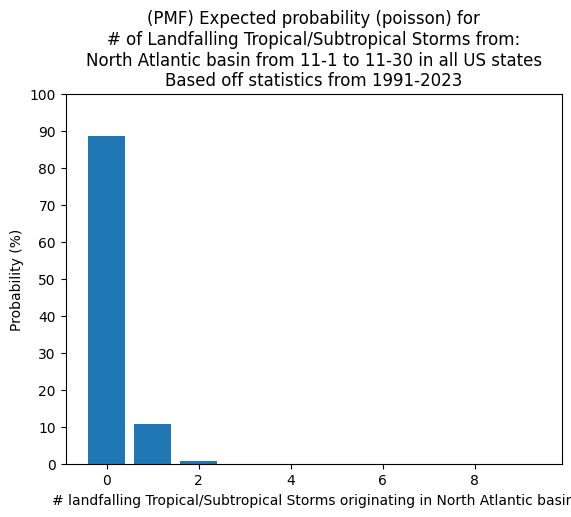

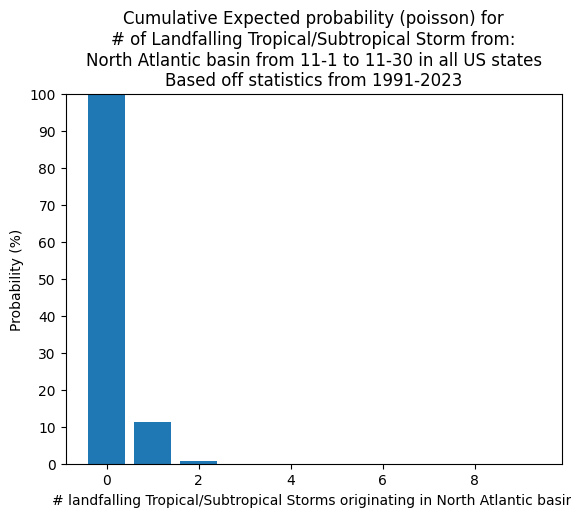

# US Hurricane landfalls in records from North Atlantic basin: 272
# US Hurricane landfalls from North Atlantic basin, 1991 to 2023 from 11-1 to 11-30 in all US states: 1
PMF % (starting from 0): [97.015150369663, 2.9398530415049398, 0.044543227901589995, 0.00044993159496555554, 3.4085726891329967e-06, 2.0658016297775737e-08, 1.0433341564533202e-10, 4.5165980798845027e-13, 1.7108326060168569e-15, 5.760379144837903e-18]
Cumulative % (starting from 0): [100.00000000000001, 2.98484963033701, 0.04499658883207003, 0.0004533609304800332, 3.4293355144776345e-06, 2.0762825344637813e-08, 1.0480904686207657e-10, 4.756312167445585e-13, 2.3971408756108255e-14, 2.2260576150091397e-14]


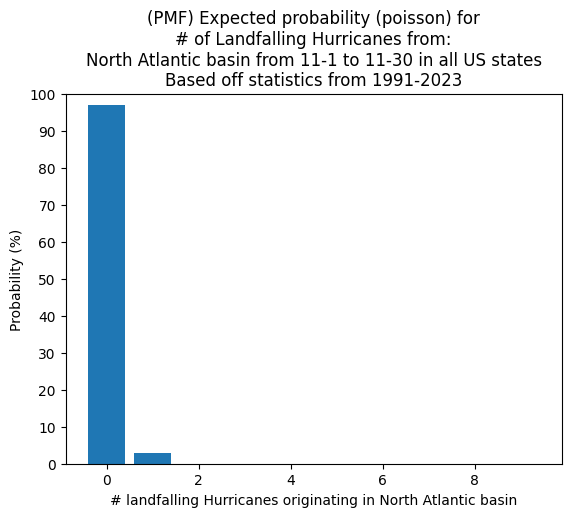

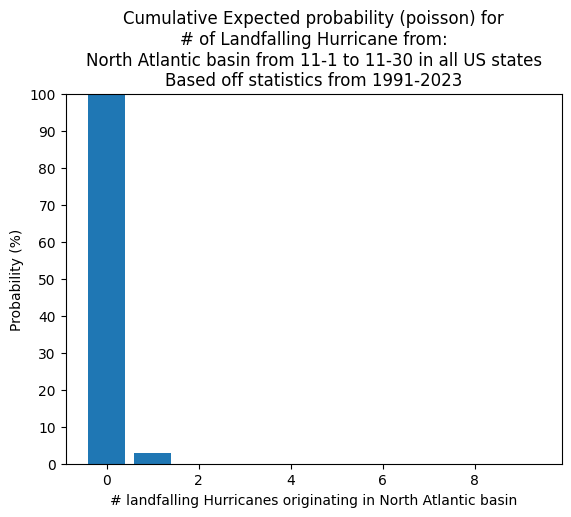

In [138]:
##### BY BASIN STATISTICS FOR US LANDFALLS
# set optionally either to None (default 1991-2023)
start_year = 1991
end_year = 2023
# must include all as None or with numbered month and day
start_month = None
start_day = None
end_month = None
end_day = None
start_month = 11
start_day = 1
end_month = 11
end_day = 30
# either None, or a list of 2 letter states to include
states = None
#states = ['NJ', 'NY']

if start_month and start_day and end_month and end_day:
    sub_period_str = f'from {start_month}-{start_day} to {end_month}-{end_day}'
else:
    sub_period_str = 'in a year'
    
states_str = 'in '
if states:
    states_str += ','.join(states)
else:
    states_str += 'all US states'
    
for basin_name, dict_dfs in dfs_by_basin.items():
    storm_types = {'TS/SS': 'Tropical/Subtropical Storm', 'HU': "Hurricane"}
    storm_type_short_to_dict_key_mapping = {'TS/SS': 'us_landfalls_ts_ss', 'HU': 'us_landfalls_hu'}
    basin_mapping = {'NA': 'North Atlantic', 'EP': 'East Pacific'}
    full_basin_name = basin_mapping[basin_name]    
    for storm_type_short, storm_type_long in storm_types.items():
        df_ref_with_state = dict_dfs[storm_type_short_to_dict_key_mapping[storm_type_short]].copy(deep=True)
        # with state has duplicate rows to record storms with multiple landfalls, so get only the unique storms for a count
        df_unique_storms = df_ref_with_state.drop_duplicates(subset=['USA_ATCF_ID'])
        df_unique_storms = df_unique_storms.reset_index(drop=True)
        print(f"# US {storm_type_long} landfalls in records from {full_basin_name} basin:", len(df_unique_storms))
        
        landfalling_in_period = get_landfalling_conditional(
            df_ref_with_state,
            states=states,
            start_year=start_year, end_year=end_year,
            start_month_num=start_month, start_day_num_of_month=start_day,
            end_month_num=end_month, end_day_num_of_month=end_day
        )

        num_years = (end_year - start_year + 1)
        num_in_period = len(landfalling_in_period)
        print(f"# US {storm_type_long} landfalls from {full_basin_name} basin, {start_year} to {end_year} {sub_period_str} {states_str}:", num_in_period)

        event_counts = list(range(0,10))
        pmf_pct_per_event_count = []
        cum_pct_per_event_count = []
        pct_total = 0
        for n in event_counts:
            pct = 100 * poisson_pmf(num_years, num_in_period, n)
            pct_total += pct
            pmf_pct_per_event_count.append(pct)

        remaining_pct = pct_total
        # get cumulative probability from pmf
        for pct in pmf_pct_per_event_count:
            cum_pct_per_event_count.append(remaining_pct)
            remaining_pct = remaining_pct - pct
        
        print("PMF % (starting from 0):", pmf_pct_per_event_count)
        print("Cumulative % (starting from 0):", cum_pct_per_event_count)
        # Create a bar chart
        # PMF
        plt.bar(event_counts, pmf_pct_per_event_count)
        
        plt.ylim(0, 100)
        plt.yticks(range(0, 101, 10))

        # Label the axes and give the chart a title
        plt.xlabel(f'# landfalling {storm_type_long}s originating in {full_basin_name} basin')
        plt.ylabel('Probability (%)')
        plt.title(f"(PMF) Expected probability (poisson) for\n# of Landfalling {storm_type_long}s from:\n" +
                  f"{full_basin_name} basin {sub_period_str} {states_str}\n" +
                  f"Based off statistics from {start_year}-{end_year}")

        # Show the chart
        plt.show()
        
        # Cumulative Probabilities chart
        plt.bar(event_counts, cum_pct_per_event_count)

        plt.ylim(0, 100)
        plt.yticks(range(0, 101, 10))

        # Label the axes and give the chart a title
        plt.xlabel(f'# landfalling {storm_type_long}s originating in {full_basin_name} basin')
        plt.ylabel('Probability (%)')
        plt.title(f"Cumulative Expected probability (poisson) for\n# of Landfalling {storm_type_long} from:\n" +
                  f"{full_basin_name} basin {sub_period_str} {states_str}\n" +
                  f"Based off statistics from {start_year}-{end_year}")
        plt.show()

# US Tropical/Subtropical Storms (>=34 kt) landfalls in records from North Atlantic and East Pacific basins: 274
# US Tropical/Subtropical Storms (>=34 kt) landfalls from North Atlantic and East Pacific basins, 1991 to 2023 from 10-25 to 11-30 in all US states: 4
PMF % (starting from 0): [88.5846032927707, 10.737527671850994, 0.6507592528394542, 0.02629330314502845, 0.0007967667619705591, 1.931555786595295e-05, 3.9021329022127176e-07, 6.756940090411631e-09, 1.02377880157752e-10, 1.3788266687912728e-12]
Cumulative % (starting from 0): [99.99999999999997, 11.415396707229277, 0.6778690353782828, 0.027109782538828564, 0.0008164793938001125, 1.9712631829553375e-05, 3.970739636004249e-07, 6.860673379153126e-09, 1.0373328874149432e-10, 1.3554085837423093e-12]


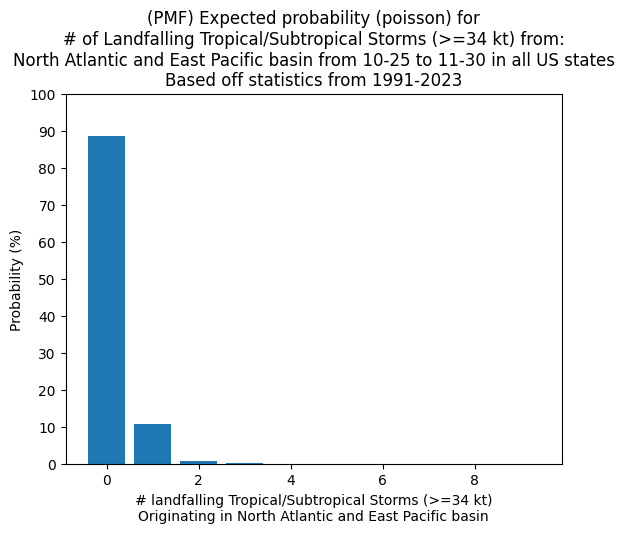

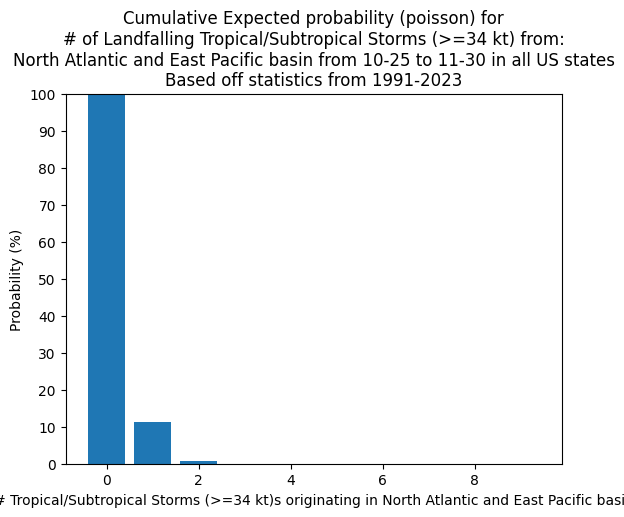

# US Hurricanes landfalls in records from North Atlantic and East Pacific basins: 273
# US Hurricanes landfalls from North Atlantic and East Pacific basins, 1991 to 2023 from 10-25 to 11-30 in all US states: 2
PMF % (starting from 0): [94.11939401248326, 5.704205697726258, 0.17285471811291692, 0.0034920145073316544, 5.290931071714628e-05, 6.41324978389652e-07, 6.4780300847439596e-09, 5.608684056055376e-11, 4.2490030727692243e-13, 2.8612815304843262e-15]
Cumulative % (starting from 0): [99.99999999999999, 5.880605987516731, 0.17640028979047262, 0.0035455716775557033, 5.3557170224048916e-05, 6.478595069026377e-07, 6.534528512985765e-09, 5.649842824180548e-11, 4.115876812517161e-13, -1.331262602520633e-14]


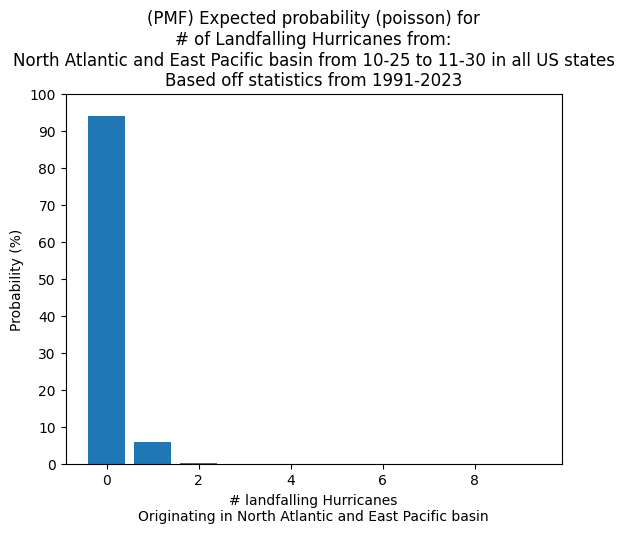

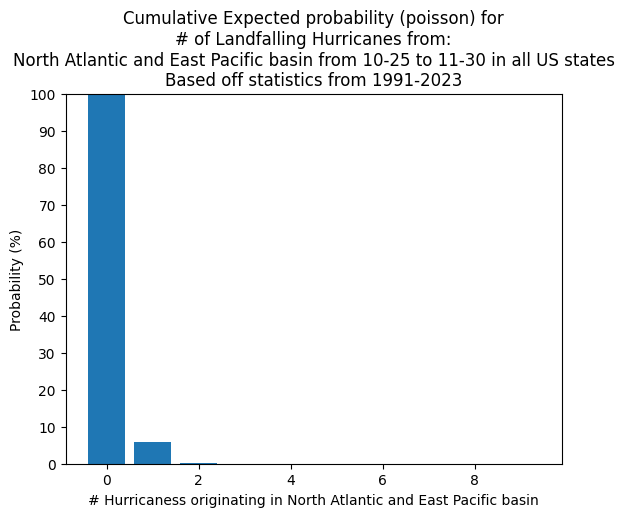

# US Named Storms (>=34 kt) landfalls in records from North Atlantic and East Pacific basins: 516
# US Named Storms (>=34 kt) landfalls from North Atlantic and East Pacific basins, 1991 to 2023 from 10-25 to 11-30 in all US states: 5
PMF % (starting from 0): [85.94048608885093, 13.021285771038022, 0.9864610432604561, 0.04982126481113416, 0.0018871691216338696, 5.7186943079814225e-05, 1.444114724237733e-06, 3.125789446402019e-08, 5.920055769700795e-10, 9.966423854715144e-12]
Cumulative % (starting from 0): [99.99999999999986, 14.059513911148926, 1.0382281401109044, 0.051767096850448224, 0.0019458320393140674, 5.86629176801978e-05, 1.475974600383573e-06, 3.185987614584001e-08, 6.019816818198177e-10, 9.976104849738216e-12]


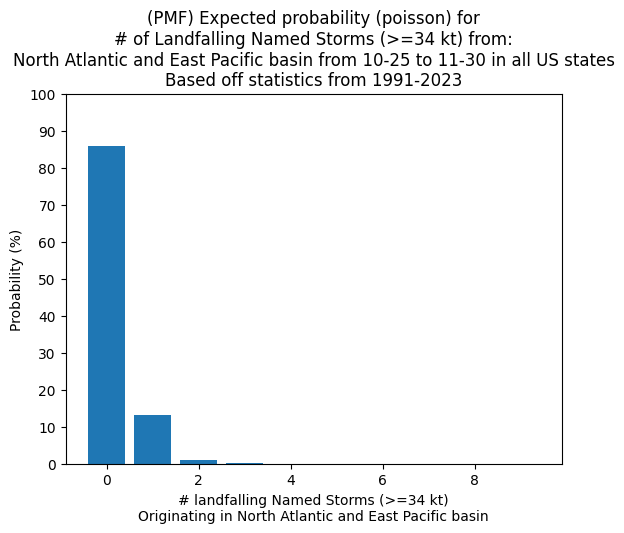

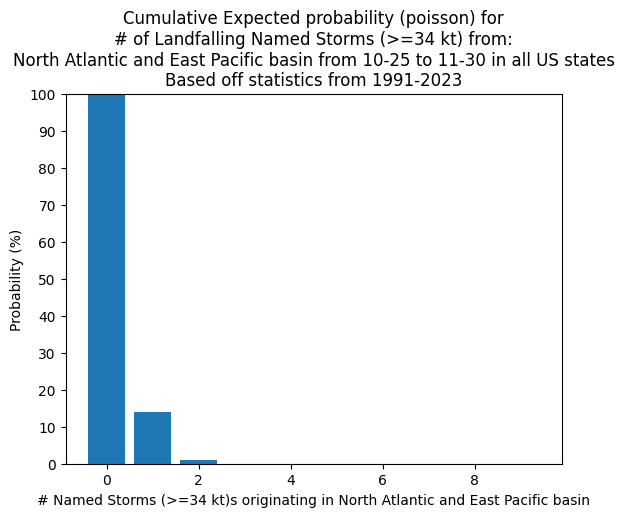

In [139]:
##### COMBINED NA AND EP BASIN STATISTICS FOR US LANDFALLS
# set optionally either to None (default 1991-2023)
start_year = 1991
end_year = 2023
# must include all as None or with numbered month and day
start_month = None
start_day = None
end_month = None
end_day = None
start_month = 10
start_day = 25
end_month = 11
end_day = 30
# either None, or a list of 2 letter states to include
states = None
#states = ['NY', 'NJ']

if start_month and start_day and end_month and end_day:
    sub_period_str = f'from {start_month}-{start_day} to {end_month}-{end_day}'
else:
    sub_period_str = 'in a year'
    
states_str = 'in '
if states:
    states_str += ','.join(states)
else:
    states_str += 'all US states'

full_basin_name = "North Atlantic and East Pacific"

storm_types = {'TS/SS': 'Tropical/Subtropical Storms (>=34 kt)', 'HU': "Hurricanes", 'TS/SS/HU': 'Named Storms (>=34 kt)'}
storm_type_short_to_dict_key_mapping = {'TS/SS': 'ts_ss', 'HU': 'hu', 'TS/SS/HU': 'ts_ss_hu'}
for storm_type_short, storm_type_long in storm_types.items():
    k = storm_type_short_to_dict_key_mapping[storm_type_short]
    df_ref_with_state = dfs_na_ep_us_landfalls[k].copy(deep=True)
    # with state has duplicate rows to record storms with multiple landfalls, so get only the unique storms for a count
    df_unique_storms = df_ref_with_state.drop_duplicates(subset=['USA_ATCF_ID'])
    df_unique_storms = df_unique_storms.reset_index(drop=True)
    print(f"# US {storm_type_long} landfalls in records from {full_basin_name} basins:", len(df_unique_storms))

    landfalling_in_period = get_landfalling_conditional(
        df_ref_with_state,
        states=states,
        start_year=start_year, end_year=end_year,
        start_month_num=start_month, start_day_num_of_month=start_day,
        end_month_num=end_month, end_day_num_of_month=end_day
    )
    
    num_years = (end_year - start_year + 1)
    num_in_period = len(landfalling_in_period)
    print(f"# US {storm_type_long} landfalls from {full_basin_name} basins, {start_year} to {end_year} {sub_period_str} {states_str}:", num_in_period)

    event_counts = list(range(0,10))
    pmf_pct_per_event_count = []
    cum_pct_per_event_count = []
    pct_total = 0
    for n in event_counts:
        pct = 100 * poisson_pmf(num_years, num_in_period, n)
        pct_total += pct
        pmf_pct_per_event_count.append(pct)
            
    remaining_pct = pct_total
    # get cumulative probability from pmf
    for pct in pmf_pct_per_event_count:
        cum_pct_per_event_count.append(remaining_pct)
        remaining_pct = remaining_pct - pct

    print("PMF % (starting from 0):", pmf_pct_per_event_count)
    print("Cumulative % (starting from 0):", cum_pct_per_event_count)
    # Create a bar chart
    # PMF
    plt.bar(event_counts, pmf_pct_per_event_count)

    plt.ylim(0, 100)
    plt.yticks(range(0, 101, 10))

    # Label the axes and give the chart a title
    plt.xlabel(f'# landfalling {storm_type_long}\nOriginating in {full_basin_name} basin')
    plt.ylabel('Probability (%)')
    plt.title(f"(PMF) Expected probability (poisson) for\n# of Landfalling {storm_type_long} from:\n" +
              f"{full_basin_name} basin {sub_period_str} {states_str}\n" +
              f"Based off statistics from {start_year}-{end_year}")

    # Show the chart
    plt.show()

    # Cumulative Probabilities chart
    plt.bar(event_counts, cum_pct_per_event_count)

    plt.ylim(0, 100)
    plt.yticks(range(0, 101, 10))

    # Label the axes and give the chart a title
    plt.xlabel(f'# {storm_type_long}s originating in {full_basin_name} basin')
    plt.ylabel('Probability (%)')
    plt.title(f"Cumulative Expected probability (poisson) for\n# of Landfalling {storm_type_long} from:\n" +
              f"{full_basin_name} basin {sub_period_str} {states_str}\n" +
              f"Based off statistics from {start_year}-{end_year}")
    plt.show()

# US Tropical/Subtropical Storm in records from East Pacific basin: 1181
# US Tropical/Subtropical Storm from East Pacific basin, 1991 to 2023 from 7-1 to 7-31: 117
PMF % (starting from 0): [2.8855503390388217, 10.230587565683095, 18.136041593710942, 21.433503701658385, 18.997878281015385, 13.47122278108364, 7.960268007003968, 4.031824055495516, 1.7868311155036942, 0.7039031667135767, 0.24956566819844989, 0.08043852115487227, 0.02376592670484863, 0.006481616374049627, 0.001641448302519061, 0.00038797868968632355, 8.597255055549214e-05, 1.793010412654649e-05, 3.531687176440975e-06, 6.590229659387466e-07, 1.1682679850732324e-07, 1.9724004942794836e-08, 3.1786619535909028e-09, 4.899913683400996e-10, 7.238508850478745e-11, 1.026552164249713e-11, 1.3998438603405174e-12, 1.8381788065077503e-13, 2.3275640731753985e-14, 2.8456112493366937e-15]
Cumulative % (starting from 0): [99.99999999999997, 97.11444966096116, 86.88386209527806, 68.74782050156712, 47.31431679990874, 28.316438518893353, 14.8

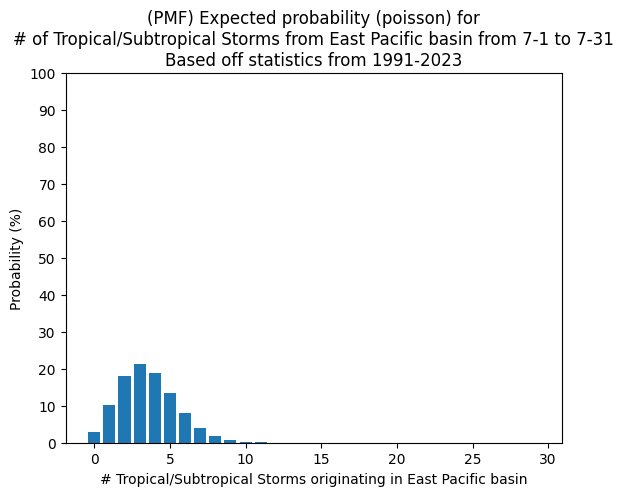

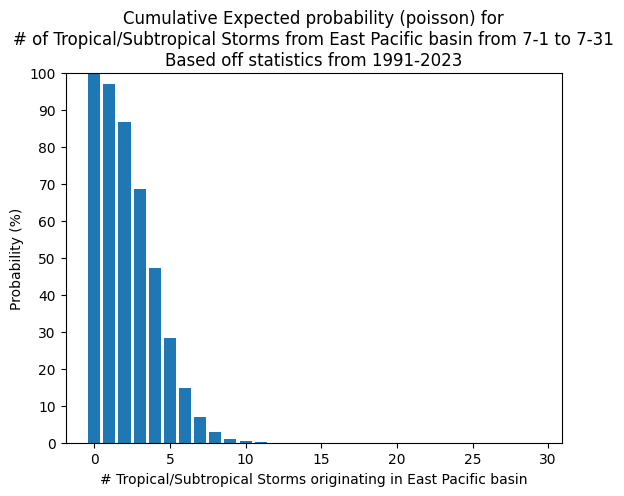

# US Hurricane in records from East Pacific basin: 601
# US Hurricane from East Pacific basin, 1991 to 2023 from 7-1 to 7-31: 68
PMF % (starting from 0): [12.73767484673777, 26.24732998721722, 27.042703623193503, 18.574786327042002, 9.568829319991332, 3.943517537935822, 1.3543393564628077, 0.3986799837206533, 0.10269029883713797, 0.023511583572139335, 0.00484481116031962, 0.0009075679308587715, 0.00015584499822827395, 2.470270368187093e-05, 3.6358957800156343e-06, 4.994765920021477e-07, 6.432653078815539e-08, 7.797155247049137e-09, 8.92603630975322e-10, 9.680549745824864e-11, 9.973899738122587e-12, 9.786799165834574e-13, 9.166698943205935e-14, 8.212589303531007e-15, 7.05121303838521e-16, 5.811908928608415e-17, 4.606174908454222e-18, 3.5153747898416063e-19, 2.587072356160489e-20, 1.8382541297692084e-21]
Cumulative % (starting from 0): [100.0, 87.26232515326222, 61.014995166045004, 33.9722915428515, 15.397505215809499, 5.828675895818167, 1.8851583578823448, 0.5308190014195371, 0.13213901

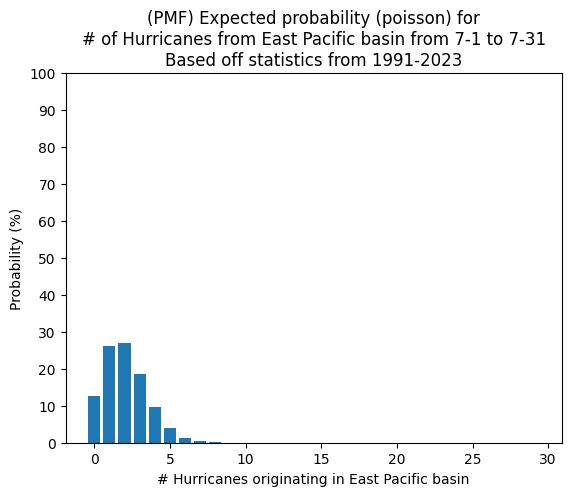

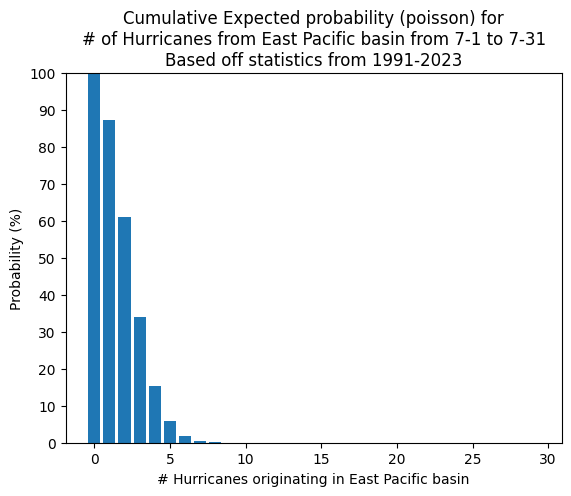

# US Named Storm in records from East Pacific basin: 1222
# US Named Storm from East Pacific basin, 1991 to 2023 from 7-1 to 7-31: 117
PMF % (starting from 0): [2.8855503390388217, 10.230587565683095, 18.136041593710942, 21.433503701658385, 18.997878281015385, 13.47122278108364, 7.960268007003968, 4.031824055495516, 1.7868311155036942, 0.7039031667135767, 0.24956566819844989, 0.08043852115487227, 0.02376592670484863, 0.006481616374049627, 0.001641448302519061, 0.00038797868968632355, 8.597255055549214e-05, 1.793010412654649e-05, 3.531687176440975e-06, 6.590229659387466e-07, 1.1682679850732324e-07, 1.9724004942794836e-08, 3.1786619535909028e-09, 4.899913683400996e-10, 7.238508850478745e-11, 1.026552164249713e-11, 1.3998438603405174e-12, 1.8381788065077503e-13, 2.3275640731753985e-14, 2.8456112493366937e-15]
Cumulative % (starting from 0): [99.99999999999997, 97.11444966096116, 86.88386209527806, 68.74782050156712, 47.31431679990874, 28.316438518893353, 14.845215737809713, 6.884947730805

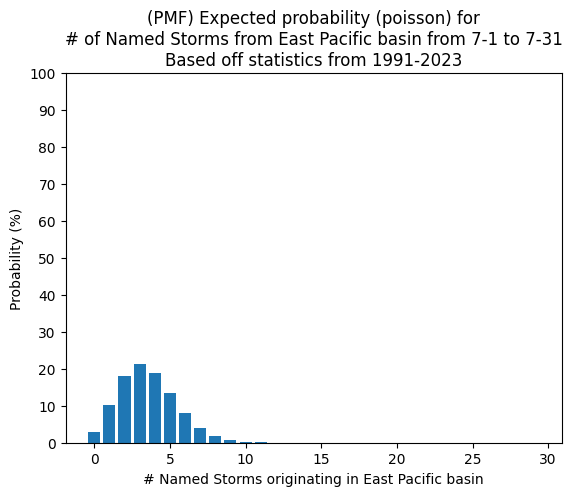

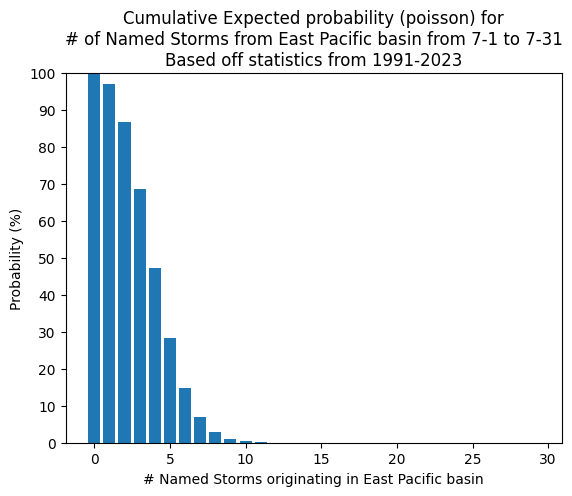

# US Tropical/Subtropical Storm in records from North Atlantic basin: 1694
# US Tropical/Subtropical Storm from North Atlantic basin, 1991 to 2023 from 7-1 to 7-31: 49
PMF % (starting from 0): [22.65366618129553, 33.63726190556003, 24.973118687461234, 12.360432481672735, 4.588342360620938, 1.3625986404268242, 0.33720875444906256, 0.07152912973161935, 0.01327623998806571, 0.0021903560923071373, 0.0003252346924940901, 4.390220367000114e-05, 5.432343383409232e-06, 6.204774493870685e-07, 6.580821432893152e-08, 6.514348489126554e-09, 6.045512802409112e-10, 5.28039442634664e-11, 4.355880924090663e-12, 3.4041174685875993e-13, 2.5272993327392785e-14, 1.7869793261792877e-15, 1.2060879749694915e-16, 7.786338705336638e-18, 4.817305512140093e-19, 2.8611875163013885e-20, 1.6340115186336597e-21, 8.98614639877097e-23, 4.765380666014909e-24, 2.43995457298569e-25]
Cumulative % (starting from 0): [100.00000000000001, 77.34633381870448, 43.70907191314445, 18.735953225683215, 6.37552074401048, 1.787178383

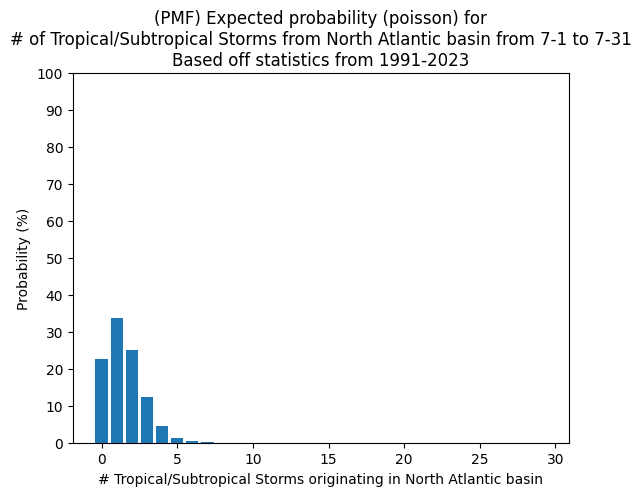

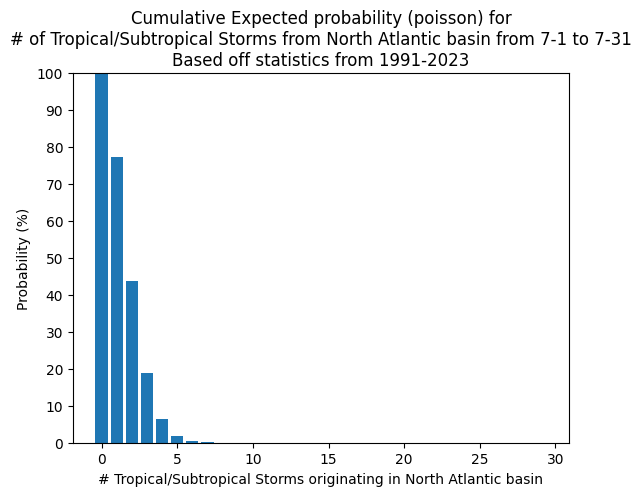

# US Hurricane in records from North Atlantic basin: 965
# US Hurricane from North Atlantic basin, 1991 to 2023 from 7-1 to 7-31: 20
PMF % (starting from 0): [54.54955638202434, 33.06033720122688, 10.018284000371782, 2.023895757650865, 0.30665087237134325, 0.03716980271167796, 0.0037545255264321174, 0.0003250671451456379, 2.462629887466954e-05, 1.6583366245568716e-06, 1.0050524997314373e-07, 5.537479337363291e-09, 2.796706736042066e-10, 1.3038259841687956e-11, 5.644268329735046e-13, 2.280512456458604e-14, 8.638304759312893e-16, 3.079609539861995e-17, 1.0369055689771026e-18, 3.3075137766414755e-20, 1.0022769020125684e-21, 2.8925740317823043e-23, 7.968523503532519e-25, 2.0997426886778706e-26, 5.30238052696432e-28, 1.2854255822943808e-29, 2.9963300286582303e-31, 6.725768863430372e-33, 1.45579412628363e-34, 3.042411967154922e-36]
Cumulative % (starting from 0): [99.99999999999999, 45.450443617975644, 12.390106416748765, 2.3718224163769825, 0.3479266587261174, 0.041275786354774135, 0.004105

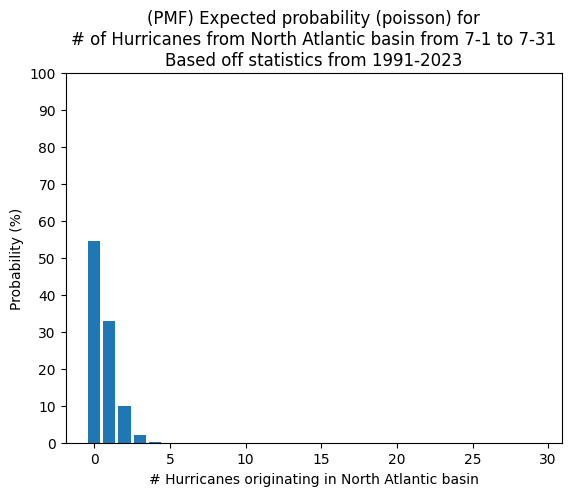

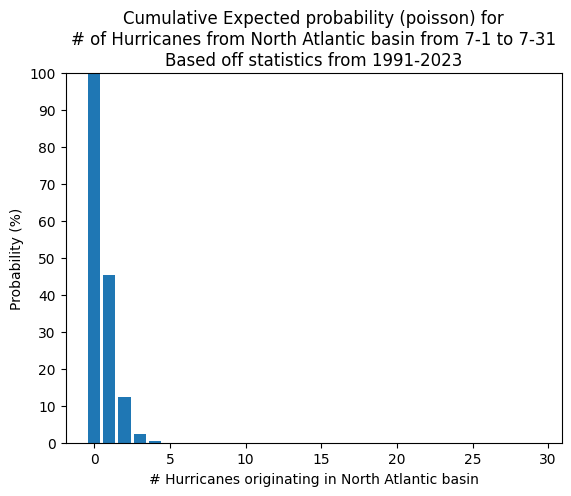

# US Named Storm in records from North Atlantic basin: 1746
# US Named Storm from North Atlantic basin, 1991 to 2023 from 7-1 to 7-31: 49
PMF % (starting from 0): [22.65366618129553, 33.63726190556003, 24.973118687461234, 12.360432481672735, 4.588342360620938, 1.3625986404268242, 0.33720875444906256, 0.07152912973161935, 0.01327623998806571, 0.0021903560923071373, 0.0003252346924940901, 4.390220367000114e-05, 5.432343383409232e-06, 6.204774493870685e-07, 6.580821432893152e-08, 6.514348489126554e-09, 6.045512802409112e-10, 5.28039442634664e-11, 4.355880924090663e-12, 3.4041174685875993e-13, 2.5272993327392785e-14, 1.7869793261792877e-15, 1.2060879749694915e-16, 7.786338705336638e-18, 4.817305512140093e-19, 2.8611875163013885e-20, 1.6340115186336597e-21, 8.98614639877097e-23, 4.765380666014909e-24, 2.43995457298569e-25]
Cumulative % (starting from 0): [100.00000000000001, 77.34633381870448, 43.70907191314445, 18.735953225683215, 6.37552074401048, 1.7871783833895414, 0.42457974296271717, 

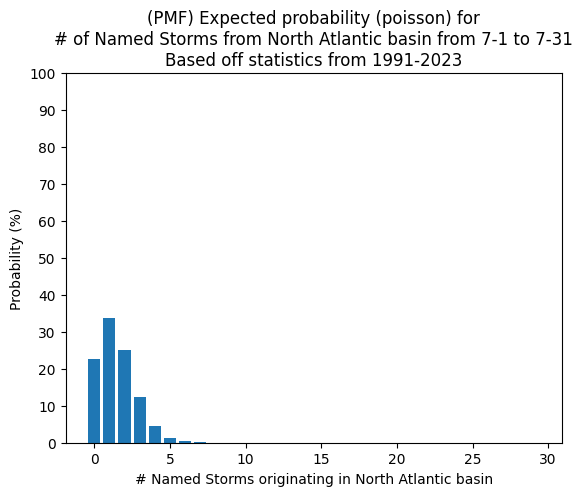

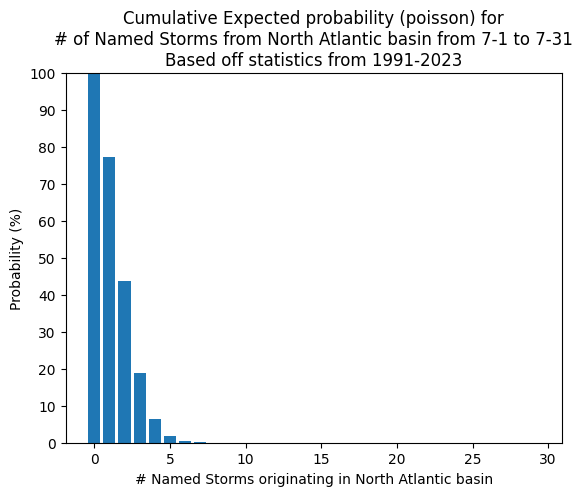

In [210]:
##### BY BASIN STATISTICS FOR STORM TYPES
# Currently, this only counts storms originating in NA basin,
#   and doesn't consider whether the storm crosses basins or which basin it strengthens in
#  Also, this only counts when the storm is at that intensity classification,
#    not necessarily when it first becomes that strength,
#    that is, it doesn't consider genesis of TS or strengthening into a hurricane timeframes,
#    just that the storm was classified such in the time frame
# set optionally either to None (default 1991-2023)
start_year = 1991
#start_year = default_start_year
end_year = 2023
# must include all as None or with numbered month and day
start_month = None
start_day = None
end_month = None
end_day = None
start_month = 7
start_day = 1
end_month = 7
end_day = 31
# don't condition on states/landfall (don't check states)
states=None

if start_month and start_day and end_month and end_day:
    sub_period_str = f'from {start_month}-{start_day} to {end_month}-{end_day}'
else:
    sub_period_str = 'in a year'

for basin_name, dict_dfs in dfs_by_basin.items():
    storm_types = {'TS/SS': 'Tropical/Subtropical Storm', 'HU': "Hurricane", "NAMED": "Named Storm"}
    storm_type_short_to_dict_key_mapping = {'TS/SS': 'ts_ss', 'HU': 'hu', 'NAMED': 'ts_ss_hu'}
    basin_mapping = {'NA': 'North Atlantic', 'EP': 'East Pacific'}
    full_basin_name = basin_mapping[basin_name]
    for storm_type_short, storm_type_long in storm_types.items():
        df_ref_with_state = dict_dfs[storm_type_short_to_dict_key_mapping[storm_type_short]].copy(deep=True)
        # with state has duplicate rows to record storms with multiple landfalls, so get only the unique storms for a count
        df_unique_storms = df_ref_with_state.drop_duplicates(subset=['USA_ATCF_ID'])
        df_unique_storms = df_unique_storms.reset_index(drop=True)
        print(f"# US {storm_type_long} in records from {full_basin_name} basin:", len(df_unique_storms))
        
        storms_in_period = get_landfalling_conditional(
            df_ref_with_state,
            states=states,
            start_year=start_year, end_year=end_year,
            start_month_num=start_month, start_day_num_of_month=start_day,
            end_month_num=end_month, end_day_num_of_month=end_day
        )
        num_years = (end_year - start_year + 1)
        num_in_period = len(storms_in_period)
        #for i in range(len(storms_in_period)):
        #    print(f"{storms_in_period.iloc[i]['SEASON']} : {storms_in_period.iloc[i]['USA_ATCF_ID']}")
        print(f"# US {storm_type_long} from {full_basin_name} basin, {start_year} to {end_year} {sub_period_str}:", num_in_period)

        event_counts = list(range(0,30))
        pmf_pct_per_event_count = []
        cum_pct_per_event_count = []
        pct_total = 0
        for n in event_counts:
            pct = 100 * poisson_pmf(num_years, num_in_period, n)
            pct_total += pct
            pmf_pct_per_event_count.append(pct)

        remaining_pct = pct_total
        # get cumulative probability from pmf
        for pct in pmf_pct_per_event_count:
            cum_pct_per_event_count.append(remaining_pct)
            remaining_pct = remaining_pct - pct

        print("PMF % (starting from 0):", pmf_pct_per_event_count)
        print("Cumulative % (starting from 0):", cum_pct_per_event_count)
        # Create a bar chart
        # PMF
        plt.bar(event_counts, pmf_pct_per_event_count)
        
        plt.ylim(0, 100)
        plt.yticks(range(0, 101, 10))

        # Label the axes and give the chart a title
        plt.xlabel(f'# {storm_type_long}s originating in {full_basin_name} basin')
        plt.ylabel('Probability (%)')
        plt.title(f"(PMF) Expected probability (poisson) for\n# of {storm_type_long}s from " +
                  f"{full_basin_name} basin {sub_period_str}\n" +
                  f"Based off statistics from {start_year}-{end_year}")
        
        # Show the chart
        plt.show()
        
        # Cumulative Probabilities chart
        plt.bar(event_counts, cum_pct_per_event_count)

        plt.ylim(0, 100)
        plt.yticks(range(0, 101, 10))

        # Label the axes and give the chart a title
        plt.xlabel(f'# {storm_type_long}s originating in {full_basin_name} basin')
        plt.ylabel('Probability (%)')
        plt.title(f"Cumulative Expected probability (poisson) for\n# of {storm_type_long}s from " +
                  f"{full_basin_name} basin {sub_period_str}\n" +
                  f"Based off statistics from {start_year}-{end_year}")

        
        # Show the chart
        plt.show()

In [141]:
pd.set_option('display.max_rows', 200)
pd.set_option('display.width', 1000)

# Get Hurricanes that made landfall as Hurricanes by Intensity Category (Saffir-Simpson)
saffir_simpson = [
    (0, 63), # Verify there are no hurricanes that are hurricane status but still <= 63 kt
    (64, 82),
    (83, 95),
    (96, 112),
    (113, 136),
    (137, math.inf)
]
na_ep_us_landfall_hurricanes = dfs_na_ep_us_landfalls['hu'].copy(deep=True)
num_na_ep_us_landfall_hurricanes = len(na_ep_us_landfall_hurricanes.copy(deep=True).drop_duplicates(subset=['USA_ATCF_ID']))
num_na_ep_us_landfall_hurricanes_multiple_landfalls = len(na_ep_us_landfall_hurricanes.copy(deep=True))
print("Total hurricanes that made landfall in the US as a hurricane by category")
print("")
print(f"Total # hurricanes made landfall in US as hurricanes (counting only 1 landfall per storm): {num_na_ep_us_landfall_hurricanes}")
print(f"Total # landfalls in US of storms as hurricanes (counting multiple landfalls per storm): {num_na_ep_us_landfall_hurricanes_multiple_landfalls}")
num_unique_hurricanes_by_cat = {}
for cat_num, cat_range in enumerate(saffir_simpson):
    cat_lower = cat_range[0]
    cat_higher = cat_range[1]
    hurricane_landfalls_in_cat_range = na_ep_us_landfall_hurricanes.loc[
        (na_ep_us_landfall_hurricanes['USA_WIND'] >= cat_lower) &
        (na_ep_us_landfall_hurricanes['USA_WIND'] <= cat_higher)
    ]
    unique_hurricanes_in_cat = hurricane_landfalls_in_cat_range.drop_duplicates(subset=['USA_ATCF_ID'])
    unique_hurricanes_in_cat = unique_hurricanes_in_cat.reset_index(drop=True)
    num_unique_hurricanes_in_cat = len(unique_hurricanes_in_cat)
    # sanity check of data
    if cat_num == 0:
        if num_unique_hurricanes_in_cat == 0:
            continue
        else:
            # this line should never be reached
            print("Error: found storms with hurricane status at landfall not having hurricane intensity")
    
    num_unique_hurricanes_by_cat[cat_num] = num_unique_hurricanes_in_cat
    
    # start index at 1
    unique_hurricanes_in_cat.index += 1
    print("")
    print("")
    print("")
    print("=====================================================================")
    print(f"# Category {cat_num} Hurricanes at US Landfall: {num_unique_hurricanes_in_cat}")
    print("=====================================================================")
    print(f"Select statistics from Category {cat_num} Hurricanes at US Landfall:")
    print("")
    print(unique_hurricanes_in_cat[['SEASON', 'NAME', 'USA_ATCF_ID', 'ISO_TIME', 'LAT', 'LON', 'USA_WIND', 'LANDFALL_STATE']])
#dfs_na_ep_us_landfalls['hu'].loc[dfs_na_ep_us_landfalls['hu']['USA_WIND'] >= 137]

print("")
print("")
print("")
print("===========================================================================")
print("Summary of Landfalling Hurricanes by Category (# unique storms per category)")
print("  * Some may have landfalled in more than one category")
print("============================================================================")
print("")
print("Category #: # Hurricanes")
print("========================")
for cat_num, num_unique_hurricanes_in_cat in num_unique_hurricanes_by_cat.items():
    print(f"Category {cat_num}: {num_unique_hurricanes_in_cat}")


Total hurricanes that made landfall in the US as a hurricane by category

Total # hurricanes made landfall in US as hurricanes (counting only 1 landfall per storm): 273
Total # landfalls in US of storms as hurricanes (counting multiple landfalls per storm): 311



# Category 1 Hurricanes at US Landfall: 122
Select statistics from Category 1 Hurricanes at US Landfall:

     SEASON       NAME USA_ATCF_ID            ISO_TIME      LAT      LON  USA_WIND LANDFALL_STATE
1      1851  NOT_NAMED    AL011851 1851-06-25 21:00:00  28.1333 -96.5667      80.0             TX
2      1852  NOT_NAMED    AL031852 1852-09-12 00:00:00  27.9333 -82.8000      70.0             FL
3      1854  NOT_NAMED    AL011854 1854-06-26 12:00:00  26.1667 -97.0667      70.0             TX
4      1858  NOT_NAMED    AL031858 1858-09-16 17:00:00  41.1181 -71.9064      80.0             NY
5      1859  NOT_NAMED    AL051859 1859-09-16 00:00:00  30.6000 -87.8333      70.0             AL
6      1859  NOT_NAMED    AL081859 1859-1

In [142]:
#https://manifold.markets/AndrewG/how-many-named-storms-will-there-be-69926f0b906d
# 80% of Tammy forming in 7 days
next_storm_genesis_prob = 1
import numpy as np
x = [25.283959580474647, 34.765444423152644, 23.90124304091744, 10.954736393753826, 3.765690635352878, 1.0355649247220413, 0.2373169619154678, 0.04661583180482404, 0.008012096091454132, 0.0012240702361943812, 0.00016830965747672742, 2.1038707184590927e-05, 2.4106851982343773e-06, 2.5497631904402063e-07, 2.504231704896631e-08, 2.295545729488579e-09, 1.9727346112792476e-10, 1.5955941708876264e-11, 1.2188566583169367e-12, 8.82067318518836e-14, 6.064212814816998e-15, 3.970615533511129e-16, 2.4816347084444555e-17, 1.4835859670048375e-18, 8.499711269298548e-20, 4.6748411981142016e-21, 2.4722717874642413e-22, 1.2590272991716042e-23, 6.182723344146271e-25, 2.9314636545521117e-26]
x0 = x[0] * (1 - next_storm_genesis_prob)
x1rest = x[1:]
new_total = x0 + np.sum(x1rest)
new_x = [np.divide(x0, 100)]
new_x.extend(np.divide(x1rest, new_total))
# 200 bet size
bet_size = 200
print(list(np.multiply(new_x, bet_size)))

[0.0, 93.06018956022587, 63.97888032265527, 29.323653481217, 10.080005884168344, 2.7720016181462945, 0.6352503708251924, 0.12478132284066282, 0.021446789863238922, 0.003276592895772613, 0.00045053152316873435, 5.6316440396091794e-05, 6.452925462052185e-06, 6.825209623324425e-07, 6.703330880050775e-08, 6.144719973379877e-09, 5.280618727123333e-10, 4.271088676349753e-11, 3.262637183322728e-12, 2.3611190142467116e-13, 1.6232693222946145e-14, 1.0628549134071877e-15, 6.642843208794923e-17, 3.9712649617795735e-18, 2.2752038843528808e-19, 1.2513621363940844e-20, 6.617780529007177e-22, 3.370166010142544e-23, 1.654992237123571e-24, 7.846945951879e-26]


In [143]:
#NS ATLANTIC
# for Oct 18th+
# [16.842748127818425, 30.001145102676567, 26.71976985707132, 15.864863352636096, 7.064821961720762, 2.5168428238630214, 0.7471877133343343, 0.19013258776811187, 0.04233420899524366, 0.00837864553030864, 0.0014924462350862267, 0.00024167453238612194, 3.587356340106497e-05, 4.915368062165153e-06, 6.253928114808342e-07, 7.426539636334905e-08, 8.26782732951347e-09, 8.662980841585803e-10, 8.572741457819285e-11, 8.03694511670558e-12, 7.157904244565908e-13, 6.071436636015725e-14, 4.91579386722864e-15, 3.807068620000442e-16, 2.8255587414065784e-17, 2.0132106032521867e-18, 1.379242841170368e-19, 9.09917152161007e-21, 5.788535454595691e-22, 3.555458199482267e-23]
# for Oct 25th
# [25.283959580474647, 34.765444423152644, 23.90124304091744, 10.954736393753826, 3.765690635352878, 1.0355649247220413, 0.2373169619154678, 0.04661583180482404, 0.008012096091454132, 0.0012240702361943812, 0.00016830965747672742, 2.1038707184590927e-05, 2.4106851982343773e-06, 2.5497631904402063e-07, 2.504231704896631e-08, 2.295545729488579e-09, 1.9727346112792476e-10, 1.5955941708876264e-11, 1.2188566583169367e-12, 8.82067318518836e-14, 6.064212814816998e-15, 3.970615533511129e-16, 2.4816347084444555e-17, 1.4835859670048375e-18, 8.499711269298548e-20, 4.6748411981142016e-21, 2.4722717874642413e-22, 1.2590272991716042e-23, 6.182723344146271e-25, 2.9314636545521117e-26]
print(list(np.multiply(2, [25.283959580474647, 34.765444423152644, 23.90124304091744, 10.954736393753826, 3.765690635352878, 1.0355649247220413, 0.2373169619154678, 0.04661583180482404, 0.008012096091454132, 0.0012240702361943812, 0.00016830965747672742, 2.1038707184590927e-05, 2.4106851982343773e-06, 2.5497631904402063e-07, 2.504231704896631e-08, 2.295545729488579e-09, 1.9727346112792476e-10, 1.5955941708876264e-11, 1.2188566583169367e-12, 8.82067318518836e-14, 6.064212814816998e-15, 3.970615533511129e-16, 2.4816347084444555e-17, 1.4835859670048375e-18, 8.499711269298548e-20, 4.6748411981142016e-21, 2.4722717874642413e-22, 1.2590272991716042e-23, 6.182723344146271e-25, 2.9314636545521117e-26])))

[50.567919160949295, 69.53088884630529, 47.80248608183488, 21.909472787507653, 7.531381270705756, 2.0711298494440826, 0.4746339238309356, 0.09323166360964807, 0.016024192182908265, 0.0024481404723887623, 0.00033661931495345483, 4.2077414369181854e-05, 4.821370396468755e-06, 5.099526380880413e-07, 5.008463409793262e-08, 4.591091458977158e-09, 3.945469222558495e-10, 3.191188341775253e-11, 2.4377133166338735e-12, 1.764134637037672e-13, 1.2128425629633996e-14, 7.941231067022258e-16, 4.963269416888911e-17, 2.967171934009675e-18, 1.6999422538597097e-19, 9.349682396228403e-21, 4.944543574928483e-22, 2.5180545983432085e-23, 1.2365446688292542e-24, 5.862927309104223e-26]


In [144]:
df_na_storms = dfs_by_basin['NA']['ts_ss_hu']
df_na_ss = df_na_storms.loc[(df_na_storms['USA_WIND'] >= 34) & (df_na_storms['USA_STATUS'].isin(['SS']))]

In [145]:
len(list(set(df_na_ss['SID'])))

107

In [146]:
sorted(list(set(df_na_ss.loc[(df_na_ss['STORM_DIR'] < 45)]['USA_ATCF_ID'])), key = lambda x:x[-4:])

['AL141967',
 'AL231967',
 'AL091968',
 'AL211969',
 'AL231969',
 'AL231970',
 'AL181970',
 'AL191970',
 'AL151970',
 'AL141972',
 'AL101972',
 'AL061973',
 'AL161973',
 'AL051974',
 'AL181974',
 'AL061974',
 'AL141976',
 'AL061977',
 'AL181979',
 'AL071980',
 'AL181980',
 'AL221981',
 'AL021982',
 'AL061983',
 'AL051984',
 'AL201984',
 'AL181984',
 'AL111991',
 'AL011992',
 'AL011997',
 'AL192000',
 'AL132001',
 'AL172001',
 'AL162001',
 'AL082002',
 'AL122002',
 'AL162004',
 'AL152004',
 'AL212005',
 'AL242005',
 'AL112007',
 'AL172010',
 'AL192011',
 'AL132011',
 'AL032012',
 'AL092013',
 'AL142013',
 'AL152013',
 'AL012015',
 'AL102016',
 'AL012016',
 'AL012018',
 'AL162018',
 'AL022018',
 'AL052018',
 'AL132018',
 'AL242020',
 'AL052023']

In [147]:
#https://manifold.markets/SaviorofPlant/will-a-tropical-or-subtropical-stor-8bb87f7ad23e
#Will a tropical or subtropical storm form in the Atlantic basin before the start of the official hurricane season?
# US Tropical/Subtropical Storm from North Atlantic basin, 1991 to 2023 from 5-15 to 5-31: 10
# PMF % (starting from 0): [73.16156289466417, 22.862988404582556, 3.5723419382160246, 0.37211895189750255, 0.029071793116992383, 0.001816987069812024, 9.463474321937625e-05, 4.224765322293583e-06, 1.650298954020931e-07, 5.730204701461565e-09, 1.790688969206739e-10, 5.087184571610054e-12, 1.324787648856785e-13, 3.1845856943672716e-15, 7.108450210641231e-17, 1.4809271272169233e-18, 2.892435795345553e-20, 5.316977564973443e-22, 9.230863828078896e-24, 1.5182341822498184e-25, 2.372240909765341e-27, 3.5301204014365197e-29, 5.014375570222328e-31, 6.813010285628162e-33, 8.871107142745005e-35, 1.1088883928431255e-36, 1.3327985490902953e-38, 1.542590913298953e-40, 1.7216416443068668e-42, 1.8552172891237788e-44]
print(100.0 - 73.16, '%')
    

26.840000000000003 %


In [148]:
# example for TD/SD to get prior probability on NHC TDs that never get upgraded to TS/SS

# US Tropical/Subtropical Depression in records from East Pacific basin: 1179
# US Tropical/Subtropical Depression from East Pacific basin, 1991 to 2023 from 5-1 to 11-30: 707
PMF % (starting from 0): [4.961005816176221e-08, 1.06285791273836e-06, 1.1385462792515463e-05, 8.130830499301447e-05, 0.00043549220931864575, 0.0018660181332623186, 0.006663004142507371, 0.020392830860401348, 0.05461261900872634, 0.13000377656286036, 0.2785232425149766, 0.5424681334933565, 0.9684973999489979, 1.5961017756735234, 2.442519383985241, 3.4886084938940707, 4.671299631028615, 5.887003278319485, 7.006921410390363, 7.90094647072725, 8.463589628491162, 8.63457123714755, 8.408597609729087, 7.832514506032233, 6.99190373202625, 5.991849622475829, 4.937339956981831, 3.917732154417683, 2.9976586939104997, 2.2145712608095334]
Cumulative % (starting from 0): [95.38728516915036, 95.38728511954031, 95.38728405668239, 95.38727267121959, 95.38719136291459, 95.38675587070527, 95.38488985257202, 95.3782268484295, 95.35

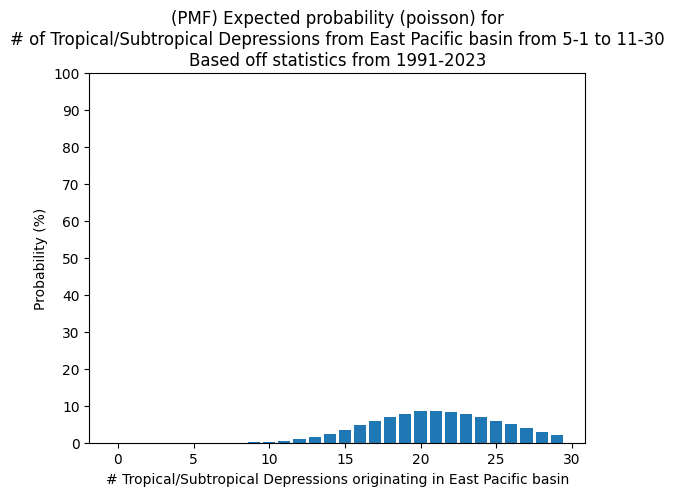

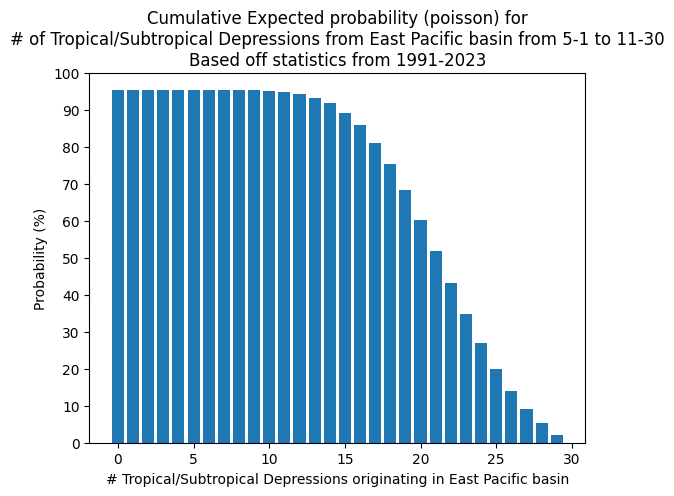

# US Tropical/Subtropical Storm in records from East Pacific basin: 1181
# US Tropical/Subtropical Storm from East Pacific basin, 1991 to 2023 from 5-1 to 11-30: 631
PMF % (starting from 0): [4.963214997493877e-07, 9.490268677026171e-06, 9.073272023035627e-05, 0.0005783065299530789, 0.002764480457578733, 0.010572043446861702, 0.03369171421701885, 0.09203234489583936, 0.21997124859573733, 0.4673463227741086, 0.8936228171832197, 1.5533774039741366, 2.475204903807273, 3.640686000704871, 4.972452091871803, 6.338620747416379, 7.575131991704044, 8.520335627032534, 9.051063603800555, 9.108805636360687, 8.708570237187262, 7.929448513225341, 6.891848501164175, 5.729586830348609, 4.564860214583299, 3.4914264186691657, 2.5677040444991177, 1.8184301370134044, 1.2418067277656473, 0.8187879260398365]
Cumulative % (starting from 0): [98.71882755457888, 98.71882705825738, 98.7188175679887, 98.71872683526847, 98.71814852873851, 98.71538404828092, 98.70481200483407, 98.67112029061705, 98.57908794572121,

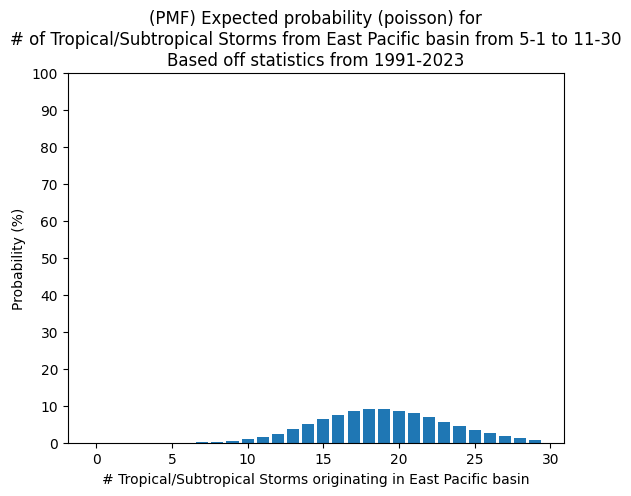

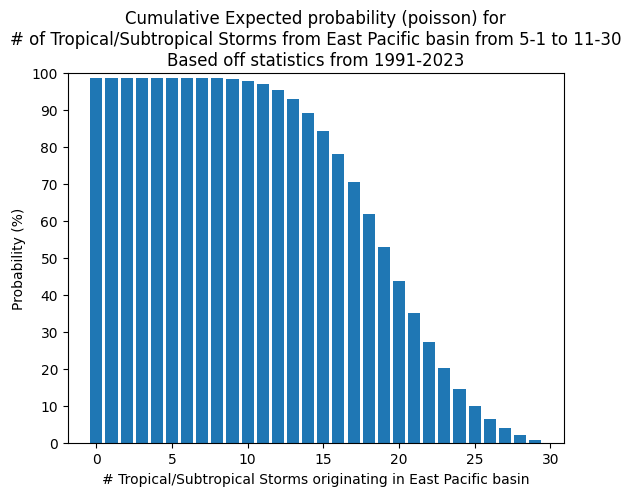

# US Hurricane in records from East Pacific basin: 601
# US Hurricane from East Pacific basin, 1991 to 2023 from 5-1 to 11-30: 298
PMF % (starting from 0): [0.01197262070055986, 0.10811639299293452, 0.4881618956347649, 1.46941661514303, 3.317319328125931, 5.991279756251684, 9.017178623045464, 11.632550777781596, 13.130682317344377, 13.174893368917928, 11.89732795132589, 9.766952422851558, 7.349878338408495, 5.105509894745295, 3.2931643909828967, 1.982551491945259, 1.1189400465903168, 0.594374570203056, 0.2981879156910955, 0.14172248624552866, 0.06398984985025384, 0.02751655881006587, 0.011294675654820428, 0.004434536686609338, 0.0016685504199615948, 0.0006027006365437032, 0.00020932959171331424, 7.001146838447547e-05, 2.2579456253867635e-05, 7.031011456272262e-06]
Cumulative % (starting from 0): [99.99999702851372, 99.98802440781316, 99.87990801482022, 99.39174611918546, 97.92232950404242, 94.60501017591649, 88.6137304196648, 79.59655179661934, 67.96400101883773, 54.833318701493354, 41

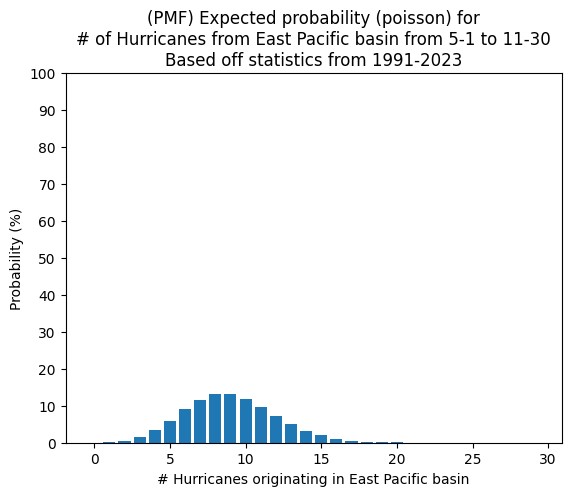

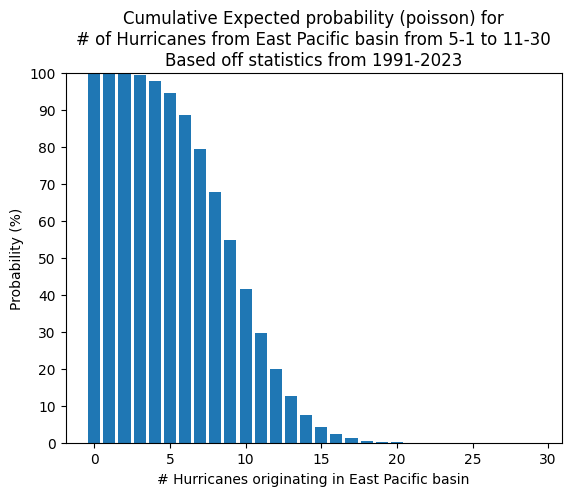

# US Named Storm in records from East Pacific basin: 1222
# US Named Storm from East Pacific basin, 1991 to 2023 from 5-1 to 11-30: 631
PMF % (starting from 0): [4.963214997493877e-07, 9.490268677026171e-06, 9.073272023035627e-05, 0.0005783065299530789, 0.002764480457578733, 0.010572043446861702, 0.03369171421701885, 0.09203234489583936, 0.21997124859573733, 0.4673463227741086, 0.8936228171832197, 1.5533774039741366, 2.475204903807273, 3.640686000704871, 4.972452091871803, 6.338620747416379, 7.575131991704044, 8.520335627032534, 9.051063603800555, 9.108805636360687, 8.708570237187262, 7.929448513225341, 6.891848501164175, 5.729586830348609, 4.564860214583299, 3.4914264186691657, 2.5677040444991177, 1.8184301370134044, 1.2418067277656473, 0.8187879260398365]
Cumulative % (starting from 0): [98.71882755457888, 98.71882705825738, 98.7188175679887, 98.71872683526847, 98.71814852873851, 98.71538404828092, 98.70481200483407, 98.67112029061705, 98.57908794572121, 98.35911669712547, 97.8917703

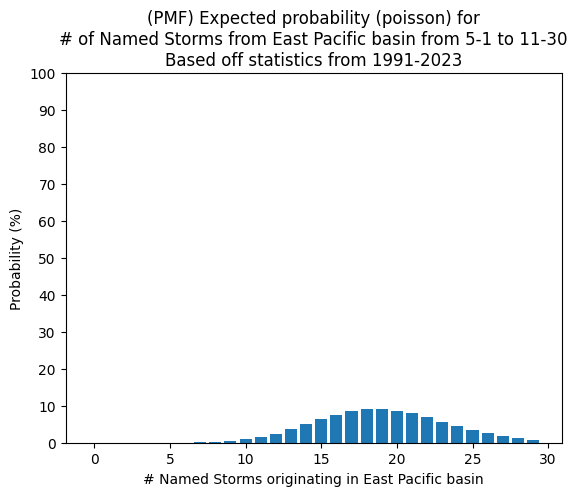

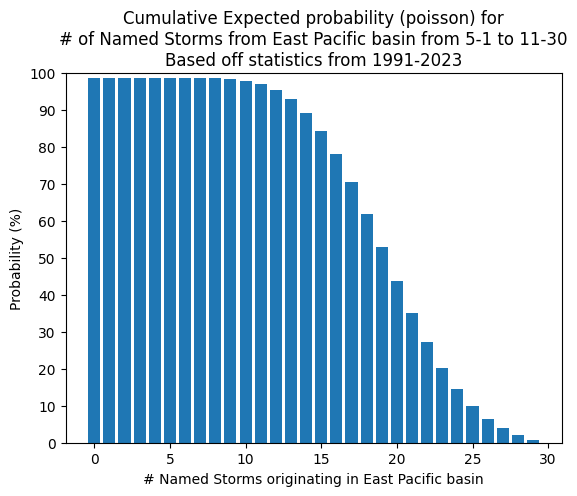

# US Tropical/Subtropical Depression in records from North Atlantic basin: 1470
# US Tropical/Subtropical Depression from North Atlantic basin, 1991 to 2023 from 5-1 to 11-30: 487
PMF % (starting from 0): [3.8982194335506096e-05, 0.0005752826861027718, 0.004244888911091664, 0.020881423229309505, 0.0770397963081343, 0.22738412607309944, 0.5592730777656536, 1.1790735448998846, 2.1750333953266807, 3.5664689007545243, 5.263243498992282, 7.061155878813337, 8.68379523480327, 9.857828156991125, 10.391260416568567, 10.223320854280594, 9.42946450006562, 8.185649218417037, 6.71112991476279, 5.212632007160253, 3.8462905871015804, 2.7029487964191485, 1.8131350741819905, 1.163368618085151, 0.715354188140743, 0.4222757449994447, 0.2396833191313864, 0.1310053607373571, 0.06904719770464601, 0.035136870723262915]
Cumulative % (starting from 0): [99.96773885622841, 99.96769987403407, 99.96712459134797, 99.96287970243688, 99.94199827920757, 99.86495848289944, 99.63757435682633, 99.07830127906068, 97.8992

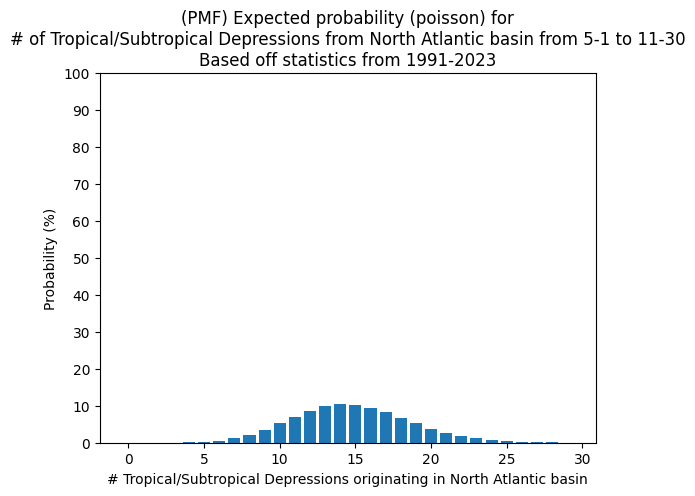

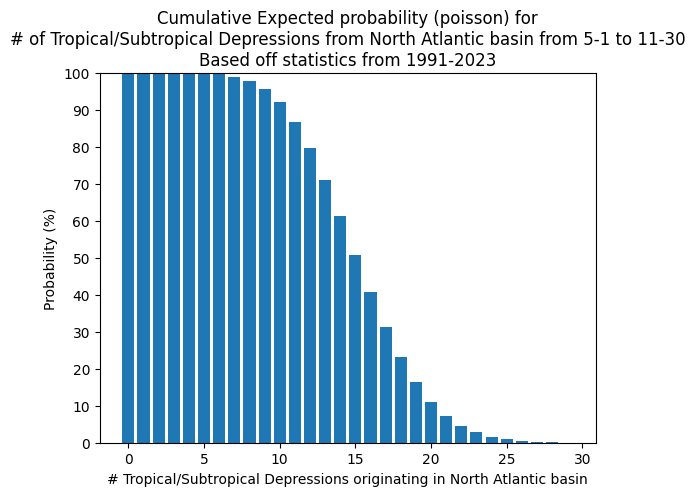

# US Tropical/Subtropical Storm in records from North Atlantic basin: 1694
# US Tropical/Subtropical Storm from North Atlantic basin, 1991 to 2023 from 5-1 to 11-30: 478
PMF % (starting from 0): [5.120474784551452e-05, 0.0007416930142471497, 0.005371655466820266, 0.02593587184989987, 0.09391929351706164, 0.2720813472797301, 0.6568428484833888, 1.3591813055197393, 2.4609419092364977, 3.960707853922714, 5.737025315681992, 7.554540222853973, 9.118864208394442, 10.160412800961636, 10.512288568960306, 10.151260476692983, 9.189966870945542, 7.830310453319019, 6.301158916980623, 4.803754325864016, 3.4790826784287874, 2.399713593490563, 1.579976718579186, 0.9950314512264176, 0.6005366586947318, 0.3479473004316143, 0.19384476644092263, 0.10399303968435579, 0.05379726511809747, 0.026870525314995397]
Cumulative % (starting from 0): [99.97615114110214, 99.97609993635429, 99.97535824334004, 99.96998658787322, 99.94405071602333, 99.85013142250627, 99.57805007522654, 98.92120722674315, 97.56202592122

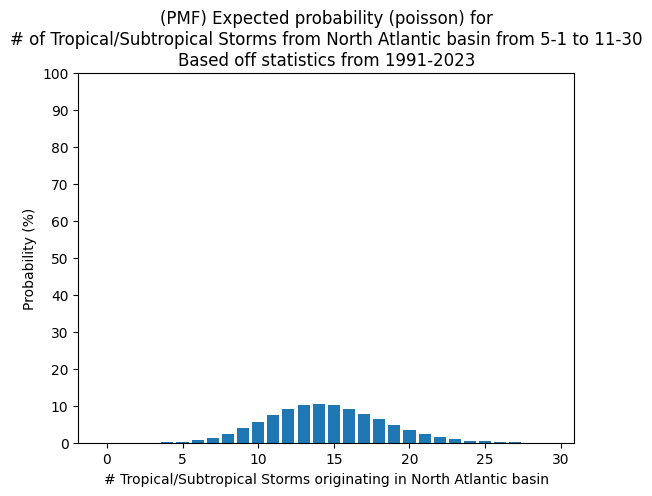

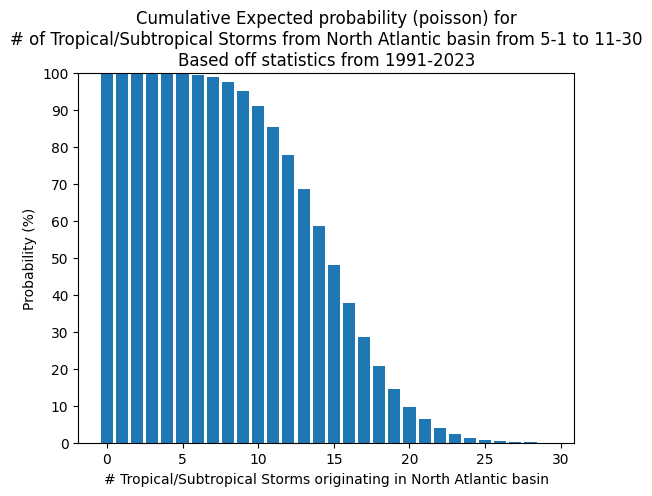

# US Hurricane in records from North Atlantic basin: 965
# US Hurricane from North Atlantic basin, 1991 to 2023 from 5-1 to 11-30: 238
PMF % (starting from 0): [0.07375909081038955, 0.5319595034203852, 1.918278209303813, 4.611618321356642, 8.314887579415764, 11.993595417581524, 14.416543986789915, 14.853408956086579, 13.3905732255629, 10.730493022504946, 7.73896163441266, 5.0740299421218, 3.0495432480428994, 1.6918211958839395, 0.8715442524250598, 0.4190455193478064, 0.18888794243329152, 0.08013427860806308, 0.032107673920402376, 0.012187601902800264, 0.004394923110403731, 0.001509367532865928, 0.0004948064363940645, 0.00015515669547007556, 4.6625370608431796e-05, 1.3450712975523355e-05, 3.7310835526509997e-06, 9.96630623491513e-07, 2.5670788786902604e-07, 6.384166908341504e-08]
Cumulative % (starting from 0): [99.99999998005403, 99.92624088924364, 99.39428138582326, 97.47600317651946, 92.86438485516281, 84.54949727574704, 72.55590185816553, 58.13935787137561, 43.285948915289026, 29.89

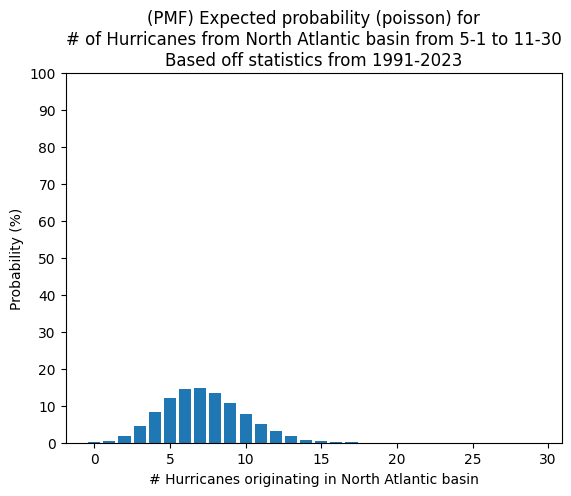

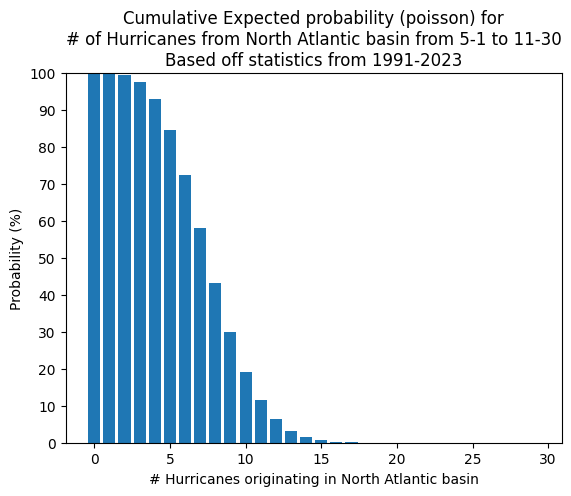

# US Named Storm in records from North Atlantic basin: 1746
# US Named Storm from North Atlantic basin, 1991 to 2023 from 5-1 to 11-30: 478
PMF % (starting from 0): [5.120474784551452e-05, 0.0007416930142471497, 0.005371655466820266, 0.02593587184989987, 0.09391929351706164, 0.2720813472797301, 0.6568428484833888, 1.3591813055197393, 2.4609419092364977, 3.960707853922714, 5.737025315681992, 7.554540222853973, 9.118864208394442, 10.160412800961636, 10.512288568960306, 10.151260476692983, 9.189966870945542, 7.830310453319019, 6.301158916980623, 4.803754325864016, 3.4790826784287874, 2.399713593490563, 1.579976718579186, 0.9950314512264176, 0.6005366586947318, 0.3479473004316143, 0.19384476644092263, 0.10399303968435579, 0.05379726511809747, 0.026870525314995397]
Cumulative % (starting from 0): [99.97615114110214, 99.97609993635429, 99.97535824334004, 99.96998658787322, 99.94405071602333, 99.85013142250627, 99.57805007522654, 98.92120722674315, 97.56202592122341, 95.10108401198691, 91.140

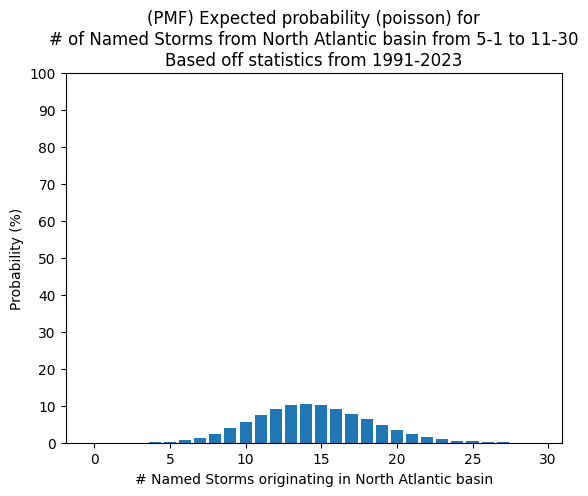

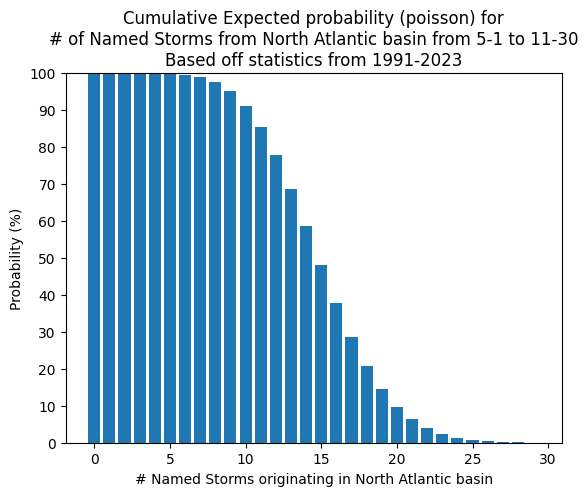

In [154]:
##### BY BASIN STATISTICS FOR STORM TYPES
# Currently, this only counts storms originating in NA basin,
#   and doesn't consider whether the storm crosses basins or which basin it strengthens in
#  Also, this only counts when the storm is at that intensity classification,
#    not necessarily when it first becomes that strength,
#    that is, it doesn't consider genesis of TS or strengthening into a hurricane timeframes,
#    just that the storm was classified such in the time frame
# set optionally either to None (default 1991-2023)
start_year = 1991
#start_year = default_start_year
end_year = 2023
# must include all as None or with numbered month and day
start_month = None
start_day = None
end_month = None
end_day = None
start_month = 5
start_day = 1
end_month = 11
end_day = 30
# don't condition on states/landfall (don't check states)
states=None

if start_month and start_day and end_month and end_day:
    sub_period_str = f'from {start_month}-{start_day} to {end_month}-{end_day}'
else:
    sub_period_str = 'in a year'

atcf_ids = []
    
for basin_name, dict_dfs in dfs_by_basin.items():
    storm_types = {'TD/SD': 'Tropical/Subtropical Depression', 'TS/SS': 'Tropical/Subtropical Storm', 'HU': "Hurricane", "NAMED": "Named Storm"}
    storm_type_short_to_dict_key_mapping = {'TD/SD': 'td_sd', 'TS/SS': 'ts_ss', 'HU': 'hu', 'NAMED': 'ts_ss_hu'}
    basin_mapping = {'NA': 'North Atlantic', 'EP': 'East Pacific'}
    full_basin_name = basin_mapping[basin_name]
    for storm_type_short, storm_type_long in storm_types.items():
        df_ref_with_state = dict_dfs[storm_type_short_to_dict_key_mapping[storm_type_short]].copy(deep=True)
        # with state has duplicate rows to record storms with multiple landfalls, so get only the unique storms for a count
        df_unique_storms = df_ref_with_state.drop_duplicates(subset=['USA_ATCF_ID'])
        df_unique_storms = df_unique_storms.reset_index(drop=True)
    
        print(f"# US {storm_type_long} in records from {full_basin_name} basin:", len(df_unique_storms))
        
        storms_in_period = get_landfalling_conditional(
            df_ref_with_state,
            states=states,
            start_year=start_year, end_year=end_year,
            start_month_num=start_month, start_day_num_of_month=start_day,
            end_month_num=end_month, end_day_num_of_month=end_day
        )
        
        atcf_ids.append(sorted(set(storms_in_period['USA_ATCF_ID'])))
        num_years = (end_year - start_year + 1)
        num_in_period = len(storms_in_period)
        #storms_in_period['USA_WIND'] >= 34
        #for i in range(len(storms_in_period)):
        #    print(f"{storms_in_period.iloc[i]['SEASON']} : {storms_in_period.iloc[i]['USA_ATCF_ID']}")
        print(f"# US {storm_type_long} from {full_basin_name} basin, {start_year} to {end_year} {sub_period_str}:", num_in_period)

        event_counts = list(range(0,30))
        pmf_pct_per_event_count = []
        cum_pct_per_event_count = []
        pct_total = 0
        for n in event_counts:
            pct = 100 * poisson_pmf(num_years, num_in_period, n)
            pct_total += pct
            pmf_pct_per_event_count.append(pct)

        remaining_pct = pct_total
        # get cumulative probability from pmf
        for pct in pmf_pct_per_event_count:
            cum_pct_per_event_count.append(remaining_pct)
            remaining_pct = remaining_pct - pct

        print("PMF % (starting from 0):", pmf_pct_per_event_count)
        print("Cumulative % (starting from 0):", cum_pct_per_event_count)
        # Create a bar chart
        # PMF
        plt.bar(event_counts, pmf_pct_per_event_count)
        
        plt.ylim(0, 100)
        plt.yticks(range(0, 101, 10))

        # Label the axes and give the chart a title
        plt.xlabel(f'# {storm_type_long}s originating in {full_basin_name} basin')
        plt.ylabel('Probability (%)')
        plt.title(f"(PMF) Expected probability (poisson) for\n# of {storm_type_long}s from " +
                  f"{full_basin_name} basin {sub_period_str}\n" +
                  f"Based off statistics from {start_year}-{end_year}")
        
        # Show the chart
        plt.show()
        
        # Cumulative Probabilities chart
        plt.bar(event_counts, cum_pct_per_event_count)

        plt.ylim(0, 100)
        plt.yticks(range(0, 101, 10))

        # Label the axes and give the chart a title
        plt.xlabel(f'# {storm_type_long}s originating in {full_basin_name} basin')
        plt.ylabel('Probability (%)')
        plt.title(f"Cumulative Expected probability (poisson) for\n# of {storm_type_long}s from " +
                  f"{full_basin_name} basin {sub_period_str}\n" +
                  f"Based off statistics from {start_year}-{end_year}")

        
        # Show the chart
        plt.show()

In [173]:
#TS's that were never a TD either because of:
#  1) genesis to immediate TS+
#  2) TS+ crossed into the basin (where USA_ATCF_ID first letters are not same basin)

In [188]:

straight_to_ts_epac = [x for x in list(set(atcf_ids[3]) - set(atcf_ids[0])) if x[1:2] == 'P']
straight_to_ts_na = [x for x in list(set(atcf_ids[7]) - set(atcf_ids[4])) if x[1:2] == 'L']
print(len(straight_to_ts_epac), len(straight_to_ts_epac) / len(list(set(atcf_ids))))
print(len(straight_to_ts_na))

12
51


In [ ]:
# TD that were never a TS because:
#  1) crossed over into basin (starting letters not in basin)
#  2) classified as a TD but never developed into a TS (strongest as a TD in it's lifetime)

In [172]:

sorted(set(atcf_ids[0]) - set(atcf_ids[3]))


['CP011994',
 'CP011996',
 'CP011997',
 'CP011998',
 'CP012001',
 'CP012003',
 'CP012004',
 'CP012005',
 'CP022006',
 'CP022009',
 'CP031992',
 'CP031997',
 'CP032006',
 'CP032013',
 'CP041997',
 'CP042006',
 'CP051997',
 'CP082015',
 'EP011995',
 'EP012009',
 'EP012016',
 'EP012018',
 'EP021992',
 'EP021996',
 'EP021998',
 'EP022004',
 'EP022006',
 'EP022010',
 'EP031993',
 'EP031997',
 'EP031999',
 'EP032002',
 'EP032007',
 'EP041999',
 'EP042000',
 'EP042007',
 'EP042019',
 'EP042020',
 'EP042023',
 'EP051991',
 'EP051997',
 'EP052000',
 'EP052007',
 'EP052008',
 'EP061996',
 'EP061999',
 'EP062001',
 'EP062004',
 'EP062010',
 'EP062020',
 'EP072002',
 'EP082010',
 'EP082011',
 'EP082015',
 'EP082017',
 'EP091999',
 'EP092004',
 'EP092009',
 'EP092018',
 'EP101991',
 'EP102010',
 'EP102020',
 'EP111999',
 'EP112002',
 'EP112010',
 'EP112015',
 'EP112017',
 'EP121992',
 'EP121994',
 'EP121996',
 'EP121998',
 'EP122011',
 'EP122023',
 'EP132007',
 'EP141993',
 'EP142001',
 'EP142023',

In [171]:
sorted(set(atcf_ids[4]) - set(atcf_ids[7]))


['AL011993',
 'AL012000',
 'AL012009',
 'AL021991',
 'AL021992',
 'AL021994',
 'AL021999',
 'AL022000',
 'AL022001',
 'AL022003',
 'AL022010',
 'AL022014',
 'AL031992',
 'AL032019',
 'AL041991',
 'AL042000',
 'AL042017',
 'AL051991',
 'AL051994',
 'AL052010',
 'AL061995',
 'AL061997',
 'AL062003',
 'AL071999',
 'AL072002',
 'AL072003',
 'AL081992',
 'AL081994',
 'AL082009',
 'AL082013',
 'AL082016',
 'AL091994',
 'AL092000',
 'AL092001',
 'AL092003',
 'AL092015',
 'AL101991',
 'AL101993',
 'AL101994',
 'AL102004',
 'AL102005',
 'AL102007',
 'AL102011',
 'AL102020',
 'AL111999',
 'AL112018',
 'AL112022',
 'AL121999',
 'AL122022',
 'AL141995',
 'AL142002',
 'AL142003',
 'AL152007',
 'AL152019',
 'AL162008',
 'AL192005',
 'AL212023',
 'AL232005',
 'EP112010',
 'EP141993']

In [ ]:
# TC STATISTICS BY MSLP

In [295]:
def plot_pressure_histogram(basin_catn_pres_values, basin_name, catn_str, start_yr, end_yr, pres_value = None):
    # Convert float data to integers
    basin_catn_pres_values_int = np.floor(basin_catn_pres_values).astype(int)

    min_mslp = np.min(basin_catn_pres_values_int)
    max_mslp = np.max(basin_catn_pres_values_int)

    # Create a complete range of bin edges including missing ones
    bin_edges = np.arange(min_mslp, max_mslp + 2)  # +2 to ensure the last value is included

    # Initialize counts for all bins
    counts = np.zeros(len(bin_edges) - 1)

    # Count occurrences for each bin
    for value in basin_catn_pres_values_int:
        if min_mslp <= value < max_mslp + 1:
            bin_index = value - min_mslp
            counts[bin_index] += 1

    # Convert counts to percentage
    counts_percentage = counts / len(basin_catn_pres_values_int) * 100

    # Calculate the center of each bin
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

    # Plot the histogram with adjusted width
    bar_width = bin_edges[1] - bin_edges[0]  # Width of one bin
    plt.bar(bin_centers, counts_percentage, width=bar_width, edgecolor='black', align='center')

    # Determine the first major tick aligned with the nearest round number divisible by 5
    first_major_tick = np.floor(min(bin_centers) / 5) * 5
    if first_major_tick < min(bin_centers):
        first_major_tick += 5

    # Generate major ticks starting from first_major_tick + 0.5
    major_ticks = np.arange(first_major_tick + 0.5, max(bin_centers), 5)

    # Set x-axis limits to ensure major ticks are centered under bars
    plt.gca().set_xlim([min(bin_centers) - bar_width / 2, max(bin_centers) + bar_width / 2])
    
    # Align major ticks with bin centers by setting ticks and limits
    plt.gca().set_xticks(major_ticks)  # Set major ticks
    plt.gca().set_xticklabels([int(tick) for tick in major_ticks])  # Ensure labels are integers

    # Set minor ticks at every bin center for better granularity (optional, but no labels here)
    plt.gca().xaxis.set_minor_locator(plt.FixedLocator(bin_centers))
    
    plt.grid(axis='y', linestyle=':', linewidth=0.5)  # Dotted grid lines on y-axis

    plt.xlabel('Pressure (hPa)')
    plt.ylabel('% of storms')
    plt.title(f'TC in {basin_name} Initial MSLP for {catn_str} ({start_yr}-{end_yr})')
    plt.show()

    # Calculate the percentile rank for the given MSLP value
    def percentile_rank(data, value):
        """Calculate the percentile rank of a value in a dataset."""
        return np.sum(data < value) / len(data) * 100

    if pres_value:
        percentile_rank_value = percentile_rank(basin_catn_pres_values_int, pres_value)

        # Print the calculated percentile rank
        print(f"Percentile rank of MSLP {pres_value}: {percentile_rank_value:.2f}%")

# Example usage:
# plot_pressure_histogram(natl_pres_values_cat1, 'NATL', 'Cat. 1', 1990, 2020, 75)


In [296]:
start_year = 1970
end_year = 2023

## CALCULATE INITIAL CLASSIFICATION FREQUENCIES BY MSLP FOR TS, CAT1 HURRICANES, etc for either basin

import numpy as np
import matplotlib.pyplot as plt

catns = {
    'TS': (34,63),
    'CAT1': (64,82),
    'CAT2': (83,95),
    'CAT3': (96,112),
    'CAT4': (113,136),
    'CAT5': (137,9999)
}

pres_by_basin_by_cat = {
    'NA': {},
    'EP': {},
}

for basin_name in ['NA', 'EP']:

    df = dfs_by_basin[basin_name]['main'].copy(deep=True)
    # Create a dictionary that specifies the data types for each column
    dtype_mapping = {
        'LAT': float,
        'LON': float,
        'WMO_WIND': float,
        'USA_PRES': float,
        'USA_WIND': float,
        'DIST2LAND': float,
        'LANDFALL': float,
        'STORM_SPEED': float,
        'STORM_DIR': float
    }

    # Apply dtype conversion to specific columns, treating non-numeric values as NaN
    for column, data_type in dtype_mapping.items():
        df[column] = pd.to_numeric(df[column], errors='coerce').astype(data_type)

    # convert time to datetime

    df['ISO_TIME'] = pd.to_datetime(df['ISO_TIME'])
    
    
    # Define the MSLP value to check against (percentage of storms that are in the category, and below that MSLP)
    year_range = list(range(start_year, end_year + 1, 1))
    
    for cat_name, cat_range in catns.items():
        cat_low = cat_range[0]
        cat_high = cat_range[1]
        if cat_name == 'TS':
            wmo_cat = 'TS'
        else:
            wmo_cat = 'HU'
        df_cat = df.loc[(df['SEASON'].isin(year_range)) & (df['USA_WIND'] >= cat_low) & (df['USA_WIND'] <= cat_high) & (df['USA_STATUS'] == wmo_cat) & (df['WMO_PRES'] != np.nan)]
        df_cat_unique = df_cat.copy(deep=True)
        # Drop rows with NaN in WMO_PRES
        df_cat_unique = df_cat_unique.dropna(subset=['USA_PRES'])
        first_rows = df_cat_unique.loc[df_cat_unique.groupby('USA_ATCF_ID')['ISO_TIME'].idxmin()]
        basin_pres_values_cat = first_rows['USA_PRES'].tolist()
        
        pres_by_basin_by_cat[basin_name][cat_name] = basin_pres_values_cat
        # plot_pressure_histogram(natl_pres_values_ts, 'NATL', 'TS', start_year, end_year, mslp)

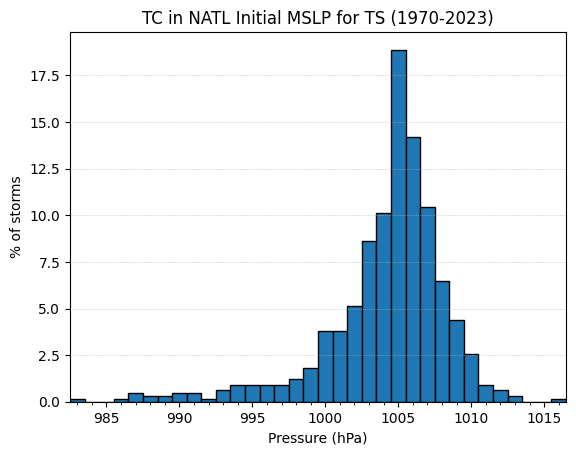

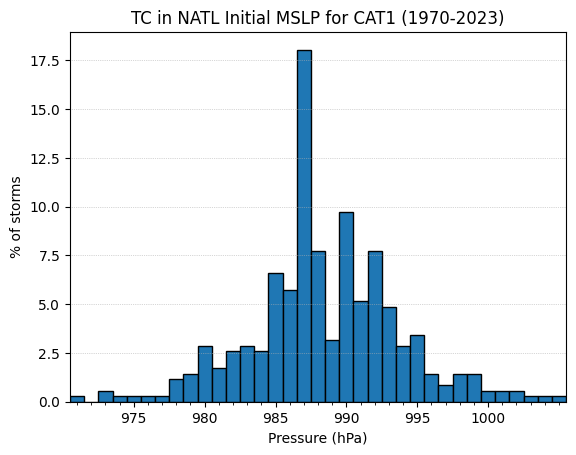

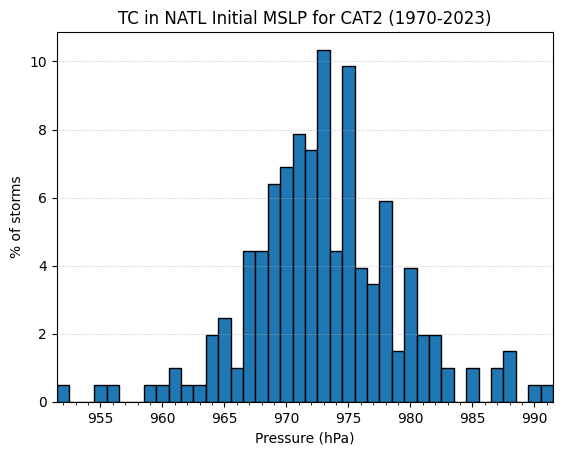

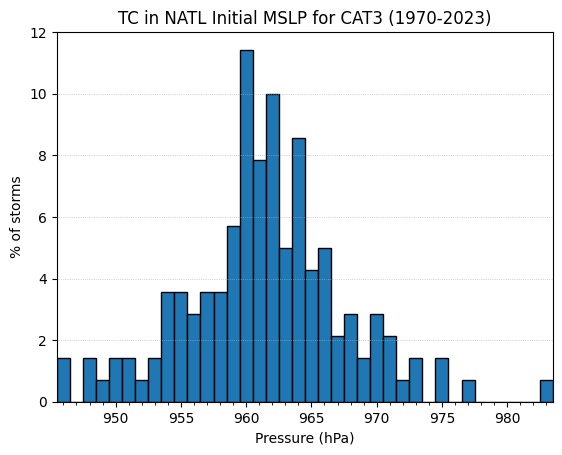

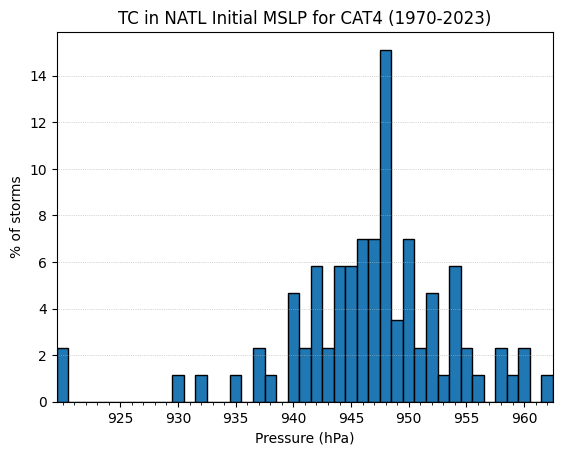

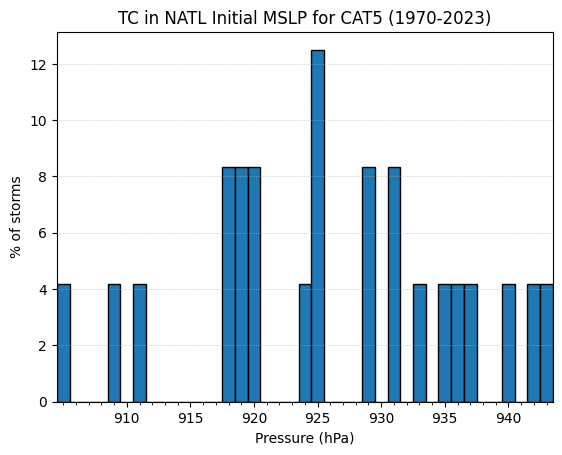

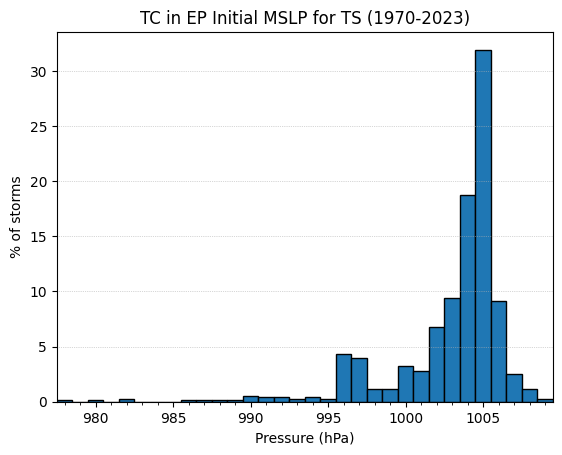

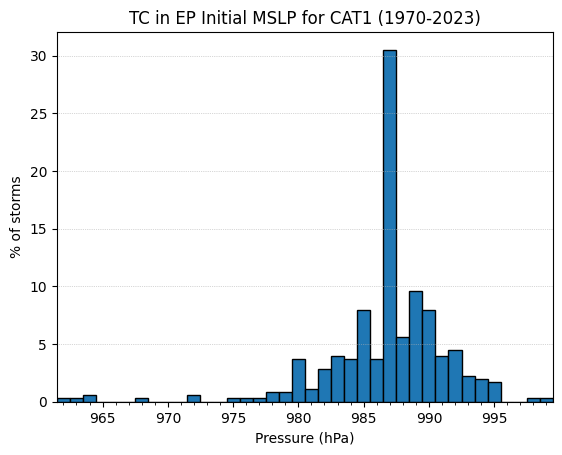

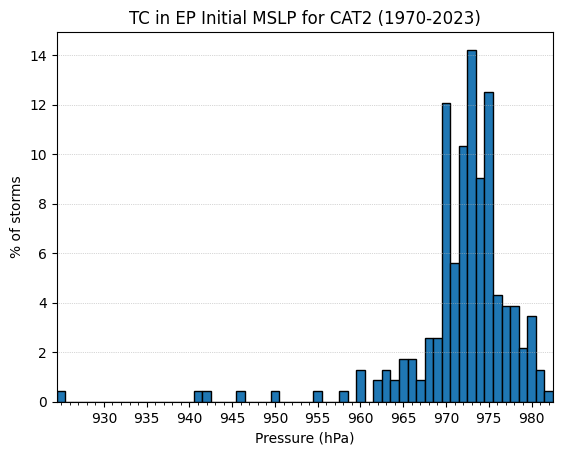

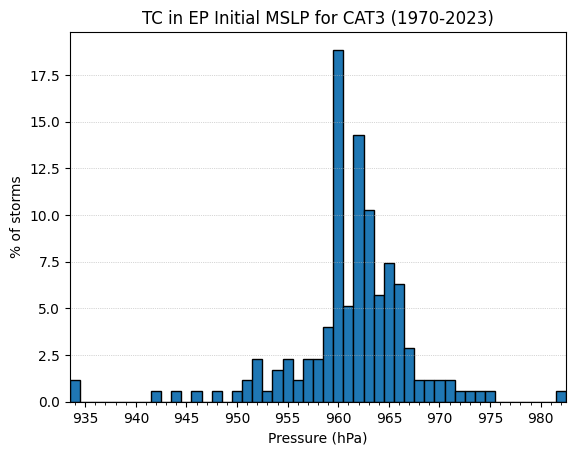

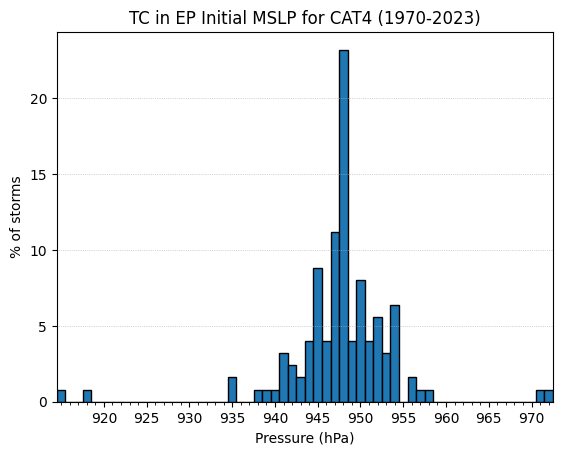

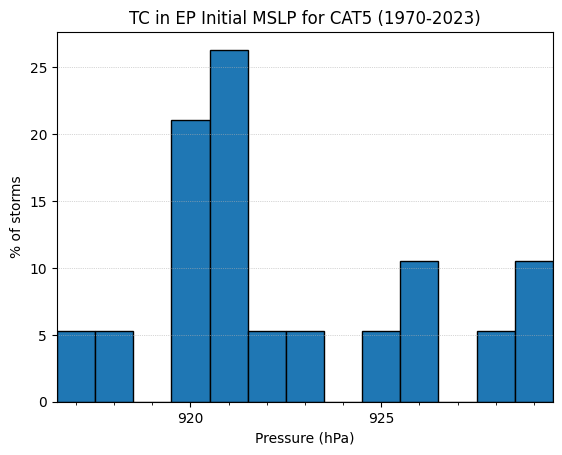

In [300]:
mslp = None
short_basin_to_long_basin = {'NA': 'NATL', 'EP': 'EP'}

for basin_name in pres_by_basin_by_cat.keys():
    for cat_name in pres_by_basin_by_cat[basin_name].keys():
        pres_values = pres_by_basin_by_cat[basin_name][cat_name]
        long_basin_name = short_basin_to_long_basin[basin_name]
        plot_pressure_histogram(pres_values, long_basin_name, cat_name, start_year, end_year, mslp)

In [ ]:
def classify_storm(basin_name, mslp, do_print=True):
    # Initialize variables to store the most likely category and its probability
    most_likely_cat = 'TD'
    most_likely_pct = 50  # Initialize to 50

    # Initialize variable to store the next lower category
    next_likely_cat = None

    # Loop over each category in the basin
    for cat in pres_by_basin_by_cat[basin_name]:
        # Calculate the percentile rank for the given MSLP value
        pct = np.sum(np.array(pres_by_basin_by_cat[basin_name][cat]) >= mslp) / len(pres_by_basin_by_cat[basin_name][cat]) * 100

        if pct > 50:
            # Update the most likely category and its probability
            next_likely_cat = most_likely_cat
            most_likely_pct = pct
            most_likely_cat = cat

            # Update the next lower category
            next_likely_pct = 100 - most_likely_pct
        # If this is the first category, set the next lower category to 'TD'
        elif next_likely_cat is None:
            most_likely_cat = 'TD'
            most_likely_pct = 100 - pct
            next_likely_cat = 'TS'
            next_likely_pct = pct
            break
        elif pct > next_likely_pct:
            next_likely_cat = cat
            next_likely_pct = pct
            most_likely_pct = 100 - pct
            break

    long_name = short_basin_to_long_basin[basin_name]
    # Print the results
    if do_print:
        print(f"The {long_name} TC with {mslp} mb is most likely to be initially classified as {most_likely_cat}.")
        print("")
        print(f"{most_likely_pct:.1f}% storms classified at this intensity ({start_year}-{end_year})")
        print("")
        print(f"The next most likely category is {next_likely_cat} with a frequency of {next_likely_pct:.1f}%")

    return [most_likely_cat, most_likely_pct, next_likely_cat, next_likely_pct]



In [299]:
classify_storm('EP', 1006)

The EP TC with 1006 mb is most likely to be initially classified as TD.

86.9% storms classified at this intensity (1970-2023)

The next most likely category is TS with a frequency of 13.1%


['TD', 86.91983122362869, 'TS', 13.080168776371309]

In [297]:
def min_max_mslp_in_basin(basin_name):
    min_mslp = np.inf
    max_mslp = -np.inf
    for cat in pres_by_basin_by_cat[basin_name].keys():
        min_mslp = min(min_mslp, np.min(np.array(pres_by_basin_by_cat[basin_name][cat])))
        max_mslp = max(max_mslp, np.max(np.array(pres_by_basin_by_cat[basin_name][cat])))
    return min_mslp, max_mslp

def get_cat_pcts_in_basin(basin_name):
    min_mslp, max_mslp = min_max_mslp_in_basin(basin_name)
    cat_pcts = {}
    for mslp in list(np.arange(min_mslp, max_mslp + 1)):
        cat_pcts[mslp] = classify_storm(basin_name, int(mslp), do_print=False)
    return cat_pcts

def plot_category_percentages(cat_pcts, basin_name, start_yr, end_yr):
    # Get unique most likely categories
    unique_cats = ['TD', 'TS', 'CAT1', 'CAT2', 'CAT3', 'CAT4', 'CAT5']
    long_name = short_basin_to_long_basin[basin_name]

    # Define a dictionary that maps each category to a color
    cat_colors = {
        'TD': 'blue',
        'TS': 'green',
        'CAT1': 'yellow',
        'CAT2': 'orange',
        'CAT3': 'red',
        'CAT4': 'purple',
        'CAT5': 'pink',
        None: 'black'
    }
    
    # Create a figure and axis for each category
    for cat in unique_cats:
        fig, ax = plt.subplots()
        
        # Filter data for this category
        cat_data = {mslp: pcts for mslp, pcts in cat_pcts.items() if pcts[0] == cat}
        cat_index = unique_cats.index(cat)
        if cat == 'TD':
            cat_higher = unique_cats[cat_index+1]
            cat_lower = None
        elif cat == 'CAT5':
            cat_higher = None
            cat_lower = unique_cats[cat_index-1]
        else:
            cat_higher = unique_cats[cat_index+1]
            cat_lower = unique_cats[cat_index-1]

        # Extract MSLP values and percentages
        mslp_values = list(cat_data.keys())
        cat1_pcts = [pcts[1] for pcts in cat_data.values()]
        cat2_pcts = [pcts[3] if pcts[2] == cat_higher else 0 for pcts in cat_data.values()]
        cat3_pcts = [pcts[3] if pcts[2] == cat_lower else 0 for pcts in cat_data.values()]

        bar_width = 0.33

        # Use the dictionary to set the color of each bar
        ax.bar([x - bar_width for x in mslp_values], cat2_pcts, width=bar_width, edgecolor='black', align='center', label=cat_higher, color=cat_colors[cat_higher])
        ax.bar([x for x in mslp_values], cat1_pcts, width=bar_width, edgecolor='black', align='center', label=cat, color=cat_colors[cat])
        ax.bar([x + bar_width for x in mslp_values], cat3_pcts, width=bar_width, edgecolor='black', align='center', label=cat_lower, color=cat_colors[cat_lower])
            
        # Set title and labels
        ax.set_title(f'TC in {long_name} initial MSLP near {cat} ({start_yr}-{end_yr})')
        ax.set_xlabel('MSLP')
        ax.set_ylabel('Percentage')

        # Set x-axis limits to ensure major ticks are centered under bars
        ax.set_xlim([min(mslp_values) - (bar_width * 2), max(mslp_values) + (bar_width * 2)])

        # Set major ticks at every 5 units
        #major_ticks = np.arange(min(mslp_values), max(mslp_values) + 1, 5)
        #ax.set_xticks(major_ticks)
        #ax.set_xticklabels([int(tick) for tick in major_ticks])

        major_ticks = [tick for tick in np.arange(min(mslp_values), max(mslp_values) + 1, 1) if tick % 5 == 0]
        ax.set_xticks(major_ticks)
        ax.set_xticklabels([int(tick) for tick in major_ticks])
        
        # Set minor ticks at every bin center for better granularity (optional, but no labels here)
        ax.xaxis.set_minor_locator(plt.FixedLocator(mslp_values))

        # Set y-axis major ticks at every 10%
        ax.set_yticks(np.arange(0, 101, 10))
        ax.set_yticklabels([str(tick) + '%' for tick in np.arange(0, 101, 10)])

        # Set y-axis minor ticks at every 5%
        ax.yaxis.set_minor_locator(plt.MultipleLocator(5))
        ax.grid(axis='y', linestyle='-', linewidth=0.4, which='major')
        ax.grid(axis='y', linestyle=':', linewidth=0.5, which='minor')

        ax.legend()

        plt.show()

def plot_all_basin_category_percentages():
    print("Estimate TC classification using initial MSLP classifications.")
    print("Uses higher/lower intensity categories and complementary percentages.")
    for basin_name in pres_by_basin_by_cat.keys():
        long_name = short_basin_to_long_basin[basin_name]
        print(f"==== {long_name} statistics by MSLP ====")
        cat_pcts = get_cat_pcts_in_basin(basin_name)
        plot_category_percentages(cat_pcts, basin_name, start_year, end_year)

Estimate TC classification using initial MSLP classifications.
Uses higher/lower intensity categories and complementary percentages.
==== NATL statistics by MSLP ====


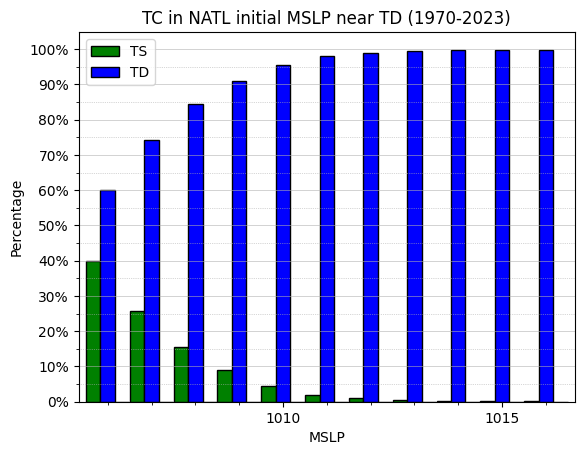

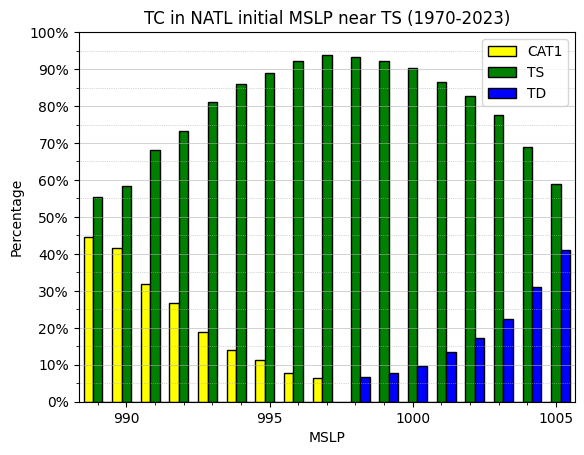

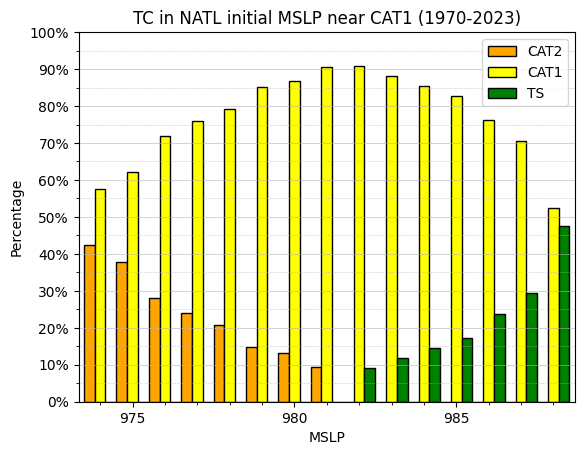

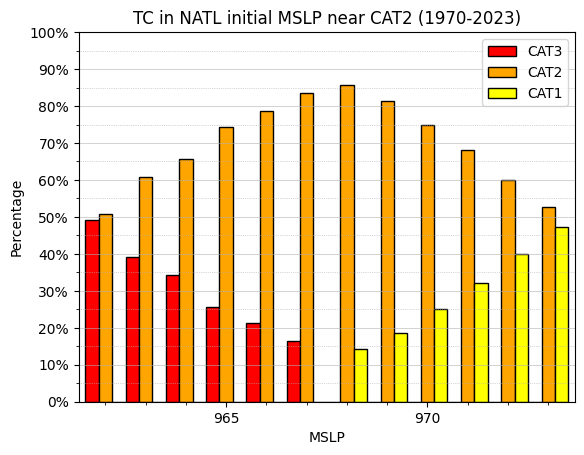

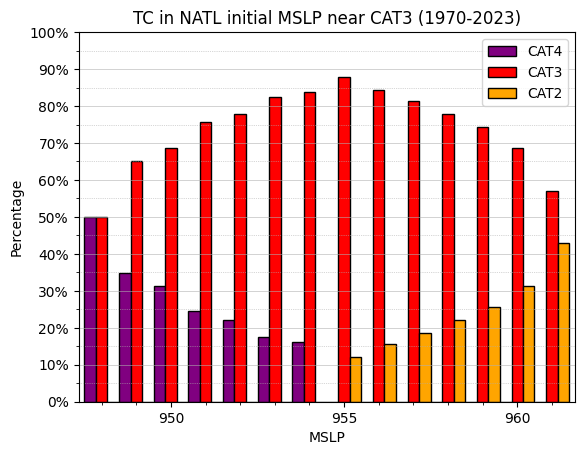

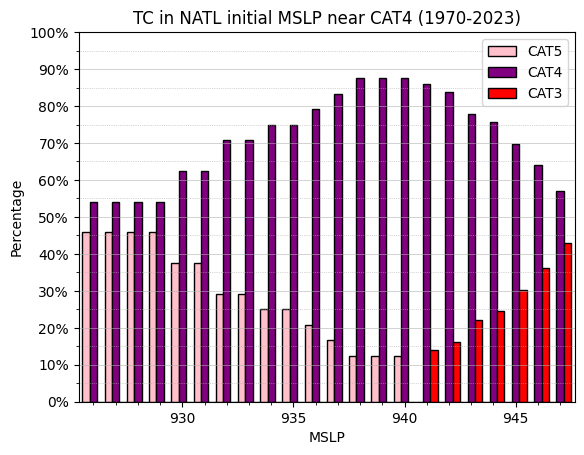

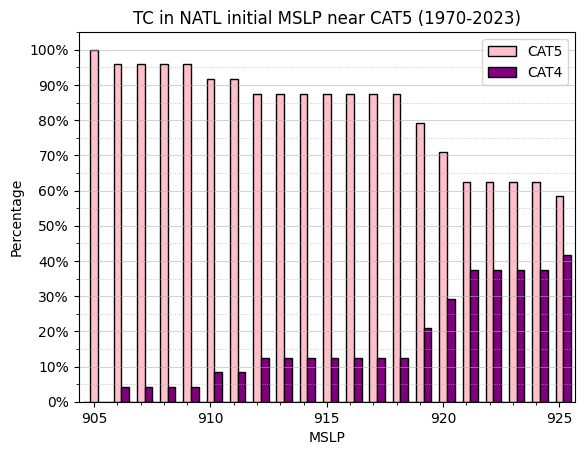

==== EP statistics by MSLP ====


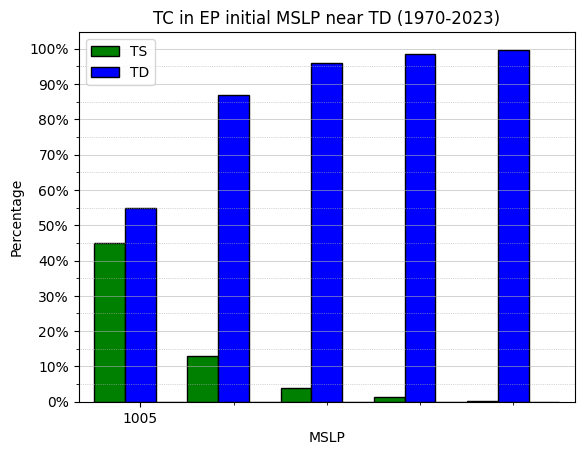

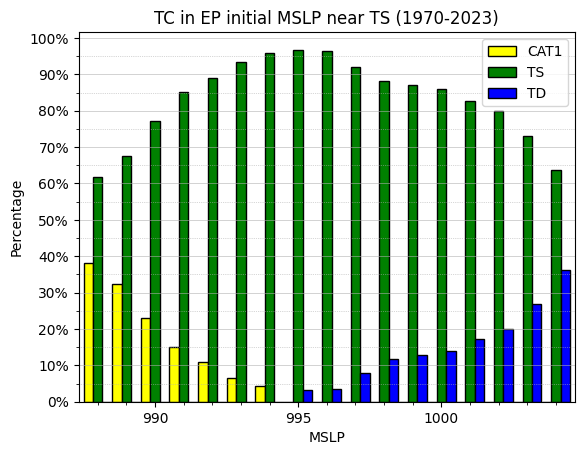

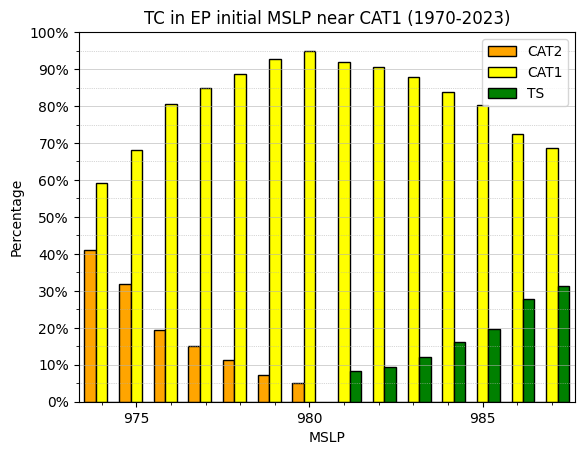

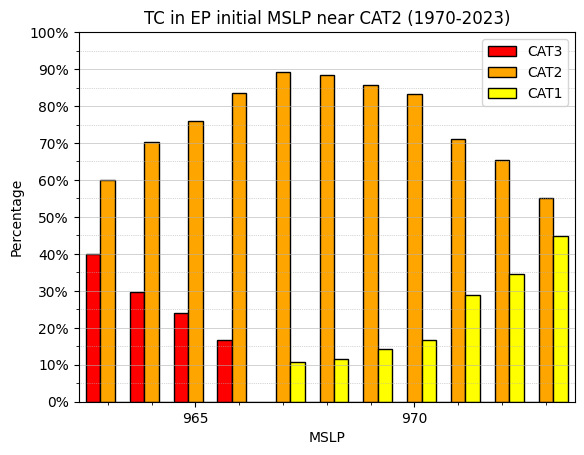

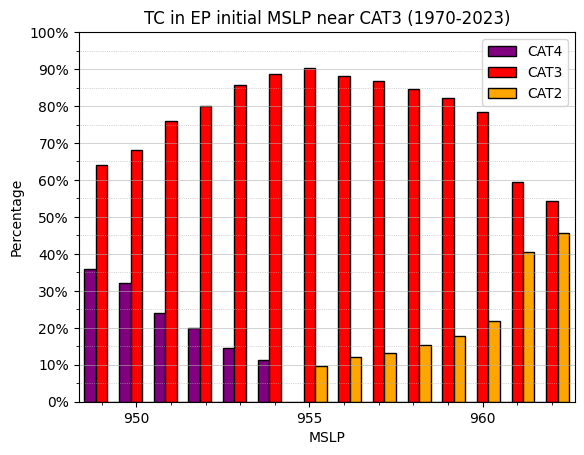

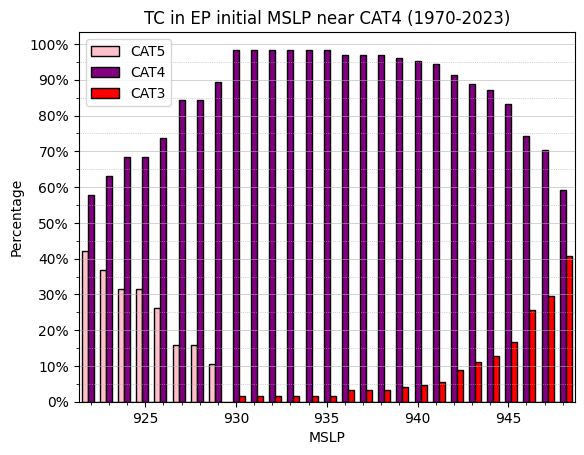

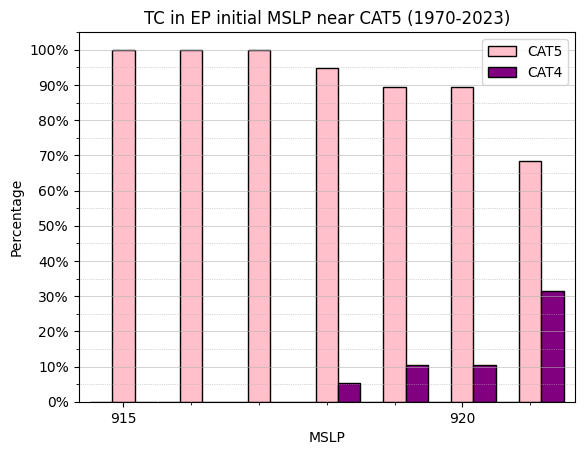

In [298]:
plot_all_basin_category_percentages()

In [225]:
states = ['FL']
min_year = 1970
pd.set_option('display.max_rows', 200)
pd.set_option('display.width', 1000)

# Get Hurricanes that made landfall as Hurricanes by Intensity Category (Saffir-Simpson)
saffir_simpson = [
    (0, 63), # Verify there are no hurricanes that are hurricane status but still <= 63 kt
    (64, 82),
    (83, 95),
    (96, 112),
    (113, 136),
    (137, math.inf)
]
na_ep_us_landfall_hurricanes = dfs_na_ep_us_landfalls['hu'].copy(deep=True)
num_na_ep_us_landfall_hurricanes = len(na_ep_us_landfall_hurricanes.copy(deep=True).drop_duplicates(subset=['USA_ATCF_ID']))
num_na_ep_us_landfall_hurricanes_multiple_landfalls = len(na_ep_us_landfall_hurricanes.copy(deep=True))
print("Total hurricanes that made landfall in the US as a hurricane by category")
print("")
print(f"Total # hurricanes made landfall in US as hurricanes (counting only 1 landfall per storm): {num_na_ep_us_landfall_hurricanes}")
print(f"Total # landfalls in US of storms as hurricanes (counting multiple landfalls per storm): {num_na_ep_us_landfall_hurricanes_multiple_landfalls}")
num_unique_hurricanes_by_cat = {}
for cat_num, cat_range in enumerate(saffir_simpson):
    cat_lower = cat_range[0]
    cat_higher = cat_range[1]
    hurricane_landfalls_in_cat_range = na_ep_us_landfall_hurricanes.loc[
        (na_ep_us_landfall_hurricanes['USA_WIND'] >= cat_lower) &
        (na_ep_us_landfall_hurricanes['USA_WIND'] <= cat_higher) & 
        (na_ep_us_landfall_hurricanes['LANDFALL_STATE'].isin(states) &
        (na_ep_us_landfall_hurricanes['SEASON'] >= min_year))
    ]
    unique_hurricanes_in_cat = hurricane_landfalls_in_cat_range.drop_duplicates(subset=['USA_ATCF_ID'])
    unique_hurricanes_in_cat = unique_hurricanes_in_cat.reset_index(drop=True)
    unique_hurricanes_in_cat = unique_hurricanes_in_cat.loc[unique_hurricanes_in_cat['LANDFALL_STATE'].isin(states)]
    num_unique_hurricanes_in_cat = len(unique_hurricanes_in_cat)
    # sanity check of data
    if cat_num == 0:
        if num_unique_hurricanes_in_cat == 0:
            continue
        else:
            # this line should never be reached
            print("Error: found storms with hurricane status at landfall not having hurricane intensity")
    
    num_unique_hurricanes_by_cat[cat_num] = num_unique_hurricanes_in_cat
    
    # start index at 1
    unique_hurricanes_in_cat.index += 1
    print("")
    print("")
    print("")
    print("=====================================================================")
    print(f"# Category {cat_num} Hurricanes Landfalling in {','.join(states)} after {min_year}: {num_unique_hurricanes_in_cat}")
    print("=====================================================================")
    print(f"Select statistics from Category {cat_num} Hurricanes at US Landfall:")
    print("")
    print(unique_hurricanes_in_cat[['SEASON', 'NAME', 'USA_ATCF_ID', 'ISO_TIME', 'LAT', 'LON', 'USA_WIND', 'LANDFALL_STATE']])

    #dfs_na_ep_us_landfalls['hu'].loc[dfs_na_ep_us_landfalls['hu']['USA_WIND'] >= 137]

print("")
print("")
print("")
print("===========================================================================")
print("Summary of Landfalling Hurricanes in {','.join(states)} after {min_year} by Category (# unique storms per category)")
print("  * Some may have landfalled in more than one category")
print("============================================================================")
print("")
print("Category #: # Hurricanes")
print("========================")
for cat_num, num_unique_hurricanes_in_cat in num_unique_hurricanes_by_cat.items():
    print(f"Category {cat_num}: {num_unique_hurricanes_in_cat}")


Total hurricanes that made landfall in the US as a hurricane by category

Total # hurricanes made landfall in US as hurricanes (counting only 1 landfall per storm): 273
Total # landfalls in US of storms as hurricanes (counting multiple landfalls per storm): 311



# Category 1 Hurricanes Landfalling in FL after 1970: 7
Select statistics from Category 1 Hurricanes at US Landfall:

   SEASON     NAME USA_ATCF_ID            ISO_TIME   LAT   LON  USA_WIND LANDFALL_STATE
1    1987    FLOYD    AL131987 1987-10-12 21:00:00  25.1 -80.5      65.0             FL
2    1995     ERIN    AL051995 1995-08-02 06:15:00  27.7 -80.3      75.0             FL
3    1998     EARL    AL051998 1998-09-03 06:00:00  30.1 -85.7      70.0             FL
4    1999    IRENE    AL131999 1999-10-15 13:00:00  24.6 -81.6      65.0             FL
5    2005  KATRINA    AL122005 2005-08-25 22:30:00  26.0 -80.1      70.0             FL
6    2016  HERMINE    AL092016 2016-09-02 05:30:00  30.1 -84.1      70.0             FL
7